
# 목표: 우리는 어떤 사람이 선거 투표에 참여하는지, 심리적 성향과 인구통계학적 정보를 가지고 예측할 수 있을까?

In [1]:
#모듈 import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import xgboost as xgb
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#데이터 불러오기
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', 100)

index = test['index']

#불필요 column 제거
Unneed_list = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE','QfE', 'QgE', 'QhE', 'QiE', 'QjE','QkE', 'QlE', 'QmE', 'QnE', 'QoE','QpE', 'QqE', 'QrE', 'QsE', 'QtE', 
               'QbA','QfA', 'QqA','tp01', 'tp03', 'index']

train.drop(Unneed_list, axis=1, inplace=True)
test.drop(Unneed_list, axis=1, inplace=True)

In [3]:
#함수 정의

#성능지표 출력 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))


<h1>데이터 전처리</h1>

---

#### 1.데이터 확인

In [4]:
#DataFrame.isnull()을 통해 train데이터에는 null값이 없는 것을 알 수 있음.
print("train 데이터 누락값 수: {}개".format(train.isnull().sum().sum()))

#describe()을 통해 결손값을 확인
train.describe()

train 데이터 누락값 수: 0개


,QaA,QcA,QdA,QeA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QrA,QsA,QtA,education,engnat,familysize,hand,married,tp02,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
count,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.00000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000,36425.000000
mean,2.131942,3.661414,1.750748,2.320494,2.560220,2.316047,3.166699,3.574084,3.822704,4.330734,3.509979,2.635772,3.213672,3.067756,2.827948,3.431187,3.224104,2.548250,1.272752,2.621002,1.170487,1.387975,2.61930,3.025614,1.333342,2.462759,2.022704,3.509952,2.272340,4.317968,2.179574,0.453178,0.080494,0.163294,0.118600,0.709623,0.934468,0.208730,0.868717,0.895072,0.329087,0.938888,0.971613,0.202663,0.945532,0.393988,0.947536,0.926781
std,1.199763,1.431303,1.046655,1.370584,1.509689,1.460773,1.482101,1.360288,1.368946,1.144399,1.375125,1.475278,1.478189,1.492889,1.426399,1.374757,1.522649,0.941273,0.449247,5.438894,0.468163,0.640297,1.89422,2.036558,1.451165,1.998749,1.779602,1.971593,1.845983,1.724866,0.761658,0.497810,0.272060,0.369639,0.323322,0.453943,0.247465,0.406407,0.337715,0.306465,0.469888,0.239539,0.166078,0.401989,0.226942,0.488639,0.222964,0.260499
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,2.000000,4.000000,1.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.00000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,3.000000,5.000000,2.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,5.000000,5.000000,3.000000,2.000000,3.000000,1.000000,2.000000,4.00000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,2.000000,999.000000,3.000000,3.000000,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---
#### 2.결손값 처리

In [5]:
#결손값이 존재 하지 않음.
#무응닶이 있는 열의 행을 삭제할려 했으나 test파일에도 무응닶이 있는 행이 있기 때문에 보류

---
#### 3.이상값 처리

In [6]:
#train데이터의 "familysize"column은 2번째로 큰 값이 44이고 제일 큰 값이 999일 정도로 매우 큰 outlier가 존재함을 알 수 있음.
print(train['familysize'].value_counts(ascending=False))

2      14321
3       9037
1       5261
4       3917
5       1521
0        983
6        662
7        313
8        175
9        102
10        48
11        29
12        16
13        10
14         7
15         7
44         3
17         3
21         2
16         2
20         2
999        1
34         1
18         1
30         1
Name: familysize, dtype: int64


In [7]:
#IQR(Inter Quantile Range)을 이용해 이상값을 처리하는 것보단 제일 큰 값인 999만 처리하는 것이 데이터적 측면에서 훨씬 탁월하다고 생각하여 max값만 제거
max_index = train['familysize'].idxmax()
train.drop(max_index, axis=0, inplace=True)
train

,QaA,QcA,QdA,QeA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QrA,QsA,QtA,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp02,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,1.0,5.0,1.0,1.0,5.0,5.0,2.0,5.0,2.0,5.0,4.0,1.0,5.0,4.0,1.0,5.0,5.0,20s,3,1,2,Male,1,1,White,Christian_Catholic,2,5,2,4,5,4,1,2,2,1,0,1,0,1,1,0,1,1,1,1,1,0,1,0,1,1
1,1.0,5.0,1.0,1.0,1.0,4.0,5.0,5.0,2.0,5.0,5.0,1.0,5.0,5.0,1.0,3.0,5.0,10s,2,2,4,Male,1,1,Asian,Hindu,0,2,0,6,1,5,5,6,3,1,0,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1
2,5.0,2.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,1.0,1.0,5.0,1.0,1.0,5.0,1.0,4.0,20s,2,1,3,Female,1,1,White,Christian_Other,1,5,3,6,0,2,1,6,2,1,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,0
3,4.0,1.0,4.0,1.0,4.0,1.0,5.0,1.0,5.0,1.0,1.0,4.0,4.0,5.0,4.0,2.0,5.0,10s,3,2,3,Male,1,1,Other,Hindu,2,5,0,1,0,2,0,4,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
4,4.0,5.0,3.0,1.0,1.0,2.0,1.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,4.0,5.0,20s,2,1,4,Female,1,1,White,Other,3,2,0,6,2,0,6,4,2,1,0,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36420,1.0,5.0,1.0,1.0,3.0,3.0,1.0,5.0,3.0,5.0,4.0,3.0,5.0,5.0,1.0,5.0,5.0,20s,2,1,6,Female,1,1,Black,Other,3,5,0,1,2,2,0,3,2,1,0,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1
36421,3.0,5.0,2.0,1.0,1.0,3.0,4.0,5.0,4.0,2.0,5.0,2.0,4.0,5.0,2.0,5.0,5.0,10s,1,2,4,Male,3,1,White,Jewish,1,6,2,5,4,6,3,6,1,0,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1
36422,2.0,2.0,1.0,2.0,4.0,2.0,2.0,4.0,5.0,5.0,4.0,1.0,5.0,2.0,1.0,5.0,3.0,30s,4,1,6,Male,1,2,White,Agnostic,2,5,1,2,1,2,1,5,2,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1
36423,5.0,1.0,3.0,5.0,4.0,1.0,4.0,2.0,5.0,5.0,4.0,5.0,2.0,1.0,1.0,2.0,4.0,40s,4,1,4,Female,3,1,White,Other,4,4,1,3,2,5,1,5,3,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1


---
#### 4. 데이터 변환

In [8]:
#'gender', 'age_group', 'race', 'religion'의 데이터는 정수형이 아니기 때문에 인코딩을 통해 데이터를 정수형으로 변환
train = pd.get_dummies(train)
test = pd.get_dummies(test)

---
#### 5.데이터 분할

In [9]:
# train에서 label값인 'vote'를 추출하여 feature값인 train_x, label값인 train_y로 분할
train_x = train.drop('voted', axis=1)
train_y = train['voted']

#train_test_split를 이용하여 학습, 테스트 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(train_x, train_y, test_size=0.2, random_state=0)


<h1>모델 학습</h1>

---

#### Decision Tree 결과

In [10]:
dt_clf = DecisionTreeClassifier(random_state=0)

#GridSearchCV로 최적의 하이퍼 파라미터 찾기

# 후보 파라미터 선정
parameters = {'max_depth':[2, 3, 5, 10], 'min_samples_split':[2, 4, 6, 8]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
grid_dtree = GridSearchCV(dt_clf, param_grid=parameters, cv=5, refit=True, scoring=make_scorer(f1_score , average='macro'))

# 파라미터 튜닝 시작
grid_dtree.fit(X_train, y_train)

estimator = grid_dtree.best_estimator_
pred = estimator.predict(X_test)

dt_pred = grid_dtree.predict(X_test)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dtree.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dtree.best_score_))
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print('테스트 데이터 세트 f1스코어: {0:.4f}'.format(f1_score(y_test, pred)))

get_clf_eval(y_test, dt_pred)

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.6847
테스트 데이터 세트 정확도: 0.6927
테스트 데이터 세트 f1스코어: 0.7024
오차행렬
[[2404 1562]
 [ 677 2642]]
정확도: 0.6927, 정밀도: 0.6284, 재현율: 0.7960, F1: 0.7024


---
#### #XGBOOST 결과

In [11]:
xgb_clf = XGBClassifier(n_estimators=100)

evals=[(X_test, y_test)]

# 후보 파라미터 선정
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3, refit=True, scoring=make_scorer(f1_score , average='macro'))

# 파라미터 튜닝 시작
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_set=evals, eval_metric='logloss', verbose=True)

estimator = gridcv.best_estimator_
pred = estimator.predict(X_test)

dt_pred = gridcv.predict(X_test)

print('GridSearchCV 최적 하이퍼 파라미터 : ', gridcv.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(gridcv.best_score_))
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print('테스트 데이터 세트 f1스코어: {0:.4f}'.format(f1_score(y_test, pred)))

get_clf_eval(y_test, dt_pred)



[0]	validation_0-logloss:0.65211
[1]	validation_0-logloss:0.61556
[2]	validation_0-logloss:0.59718
[3]	validation_0-logloss:0.58506
[4]	validation_0-logloss:0.57636
[5]	validation_0-logloss:0.56968
[6]	validation_0-logloss:0.56661
[7]	validation_0-logloss:0.56542
[8]	validation_0-logloss:0.56311
[9]	validation_0-logloss:0.56120
[10]	validation_0-logloss:0.56006
[11]	validation_0-logloss:0.55926
[12]	validation_0-logloss:0.55905
[13]	validation_0-logloss:0.55864
[14]	validation_0-logloss:0.55856
[15]	validation_0-logloss:0.55824
[16]	validation_0-logloss:0.55821
[17]	validation_0-logloss:0.55901
[18]	validation_0-logloss:0.55915
[19]	validation_0-logloss:0.55961
[20]	validation_0-logloss:0.55919
[21]	validation_0-logloss:0.55916
[22]	validation_0-logloss:0.55943
[23]	validation_0-logloss:0.55928
[24]	validation_0-logloss:0.55961
[25]	validation_0-logloss:0.55964
[26]	validation_0-logloss:0.55978
[27]	validation_0-logloss:0.55920
[28]	validation_0-logloss:0.55932
[29]	validation_0-loglos

[41]	validation_0-logloss:0.56331
[42]	validation_0-logloss:0.56342
[43]	validation_0-logloss:0.56360
[44]	validation_0-logloss:0.56387
[0]	validation_0-logloss:0.65141
[1]	validation_0-logloss:0.61599
[2]	validation_0-logloss:0.59829
[3]	validation_0-logloss:0.58609
[4]	validation_0-logloss:0.57708
[5]	validation_0-logloss:0.57056
[6]	validation_0-logloss:0.56803
[7]	validation_0-logloss:0.56676
[8]	validation_0-logloss:0.56452
[9]	validation_0-logloss:0.56190
[10]	validation_0-logloss:0.56044
[11]	validation_0-logloss:0.56031
[12]	validation_0-logloss:0.55941
[13]	validation_0-logloss:0.55871
[14]	validation_0-logloss:0.55810
[15]	validation_0-logloss:0.55788
[16]	validation_0-logloss:0.55788
[17]	validation_0-logloss:0.55795
[18]	validation_0-logloss:0.55827
[19]	validation_0-logloss:0.55849
[20]	validation_0-logloss:0.55855
[21]	validation_0-logloss:0.55815
[22]	validation_0-logloss:0.55810
[23]	validation_0-logloss:0.55818
[24]	validation_0-logloss:0.55822
[25]	validation_0-loglos

[19]	validation_0-logloss:0.56532
[20]	validation_0-logloss:0.56560
[21]	validation_0-logloss:0.56693
[22]	validation_0-logloss:0.56737
[23]	validation_0-logloss:0.56869
[24]	validation_0-logloss:0.56902
[25]	validation_0-logloss:0.56923
[26]	validation_0-logloss:0.57005
[27]	validation_0-logloss:0.56987
[28]	validation_0-logloss:0.57083
[29]	validation_0-logloss:0.57162
[30]	validation_0-logloss:0.57170
[31]	validation_0-logloss:0.57205
[32]	validation_0-logloss:0.57191
[33]	validation_0-logloss:0.57198
[34]	validation_0-logloss:0.57208
[35]	validation_0-logloss:0.57263
[36]	validation_0-logloss:0.57282
[37]	validation_0-logloss:0.57389
[38]	validation_0-logloss:0.57453
[39]	validation_0-logloss:0.57513
[40]	validation_0-logloss:0.57516
[0]	validation_0-logloss:0.65053
[1]	validation_0-logloss:0.61454
[2]	validation_0-logloss:0.59656
[3]	validation_0-logloss:0.58417
[4]	validation_0-logloss:0.57568
[5]	validation_0-logloss:0.56991
[6]	validation_0-logloss:0.56688
[7]	validation_0-logl

[36]	validation_0-logloss:0.55893
[37]	validation_0-logloss:0.55942
[38]	validation_0-logloss:0.55958
[39]	validation_0-logloss:0.55977
[40]	validation_0-logloss:0.55974
[41]	validation_0-logloss:0.56011
[42]	validation_0-logloss:0.56023
[43]	validation_0-logloss:0.55982
[0]	validation_0-logloss:0.64638
[1]	validation_0-logloss:0.61087
[2]	validation_0-logloss:0.59047
[3]	validation_0-logloss:0.57889
[4]	validation_0-logloss:0.57062
[5]	validation_0-logloss:0.56533
[6]	validation_0-logloss:0.56209
[7]	validation_0-logloss:0.56030
[8]	validation_0-logloss:0.55954
[9]	validation_0-logloss:0.55856
[10]	validation_0-logloss:0.55751
[11]	validation_0-logloss:0.55704
[12]	validation_0-logloss:0.55649
[13]	validation_0-logloss:0.55607
[14]	validation_0-logloss:0.55597
[15]	validation_0-logloss:0.55609
[16]	validation_0-logloss:0.55633
[17]	validation_0-logloss:0.55611
[18]	validation_0-logloss:0.55604
[19]	validation_0-logloss:0.55607
[20]	validation_0-logloss:0.55617
[21]	validation_0-loglos

[18]	validation_0-logloss:0.56380
[19]	validation_0-logloss:0.56432
[20]	validation_0-logloss:0.56439
[21]	validation_0-logloss:0.56428
[22]	validation_0-logloss:0.56479
[23]	validation_0-logloss:0.56583
[24]	validation_0-logloss:0.56664
[25]	validation_0-logloss:0.56672
[26]	validation_0-logloss:0.56678
[27]	validation_0-logloss:0.56637
[28]	validation_0-logloss:0.56690
[29]	validation_0-logloss:0.56751
[30]	validation_0-logloss:0.56804
[31]	validation_0-logloss:0.56836
[32]	validation_0-logloss:0.56869
[33]	validation_0-logloss:0.56974
[34]	validation_0-logloss:0.57023
[35]	validation_0-logloss:0.57156
[36]	validation_0-logloss:0.57230
[37]	validation_0-logloss:0.57299
[38]	validation_0-logloss:0.57299
[39]	validation_0-logloss:0.57374
[40]	validation_0-logloss:0.57422
[0]	validation_0-logloss:0.64384
[1]	validation_0-logloss:0.60906
[2]	validation_0-logloss:0.58831
[3]	validation_0-logloss:0.57794
[4]	validation_0-logloss:0.57003
[5]	validation_0-logloss:0.56511
[6]	validation_0-log

---
#### #LightGBM 결과

In [12]:
lgbm_clf = LGBMClassifier()

evals = [(X_test, y_test)]

# 후보 파라미터 선정
parameters = {
    'n_estimators': [200, 400],
    'num_leaves': [10, 31, 64],
    'min_child_samples' : [20, 100],
    'learning_rate': [0.01, 0.001]
}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
grid_lgbm = GridSearchCV(lgbm_clf, param_grid=parameters, cv=3, refit=True, scoring=make_scorer(f1_score , average='macro'))

# 파라미터 튜닝 시작
grid_lgbm.fit(X_train, y_train, early_stopping_rounds=80, eval_metric='logloss', eval_set=evals, verbose=True)

estimator = grid_lgbm.best_estimator_
pred = estimator.predict(X_test)

dt_pred = grid_lgbm.predict(X_test)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_lgbm.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lgbm.best_score_))
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print('테스트 데이터 세트 f1스코어: {0:.4f}'.format(f1_score(y_test, pred)))

get_clf_eval(y_test, dt_pred)

[1]	valid_0's binary_logloss: 0.687175
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.685172
[3]	valid_0's binary_logloss: 0.68321
[4]	valid_0's binary_logloss: 0.681273
[5]	valid_0's binary_logloss: 0.679382
[6]	valid_0's binary_logloss: 0.677528
[7]	valid_0's binary_logloss: 0.675697
[8]	valid_0's binary_logloss: 0.673909
[9]	valid_0's binary_logloss: 0.672145
[10]	valid_0's binary_logloss: 0.670425
[11]	valid_0's binary_logloss: 0.668733
[12]	valid_0's binary_logloss: 0.667064
[13]	valid_0's binary_logloss: 0.665433
[14]	valid_0's binary_logloss: 0.663813
[15]	valid_0's binary_logloss: 0.662222
[16]	valid_0's binary_logloss: 0.66068
[17]	valid_0's binary_logloss: 0.659145
[18]	valid_0's binary_logloss: 0.657638
[19]	valid_0's binary_logloss: 0.656159
[20]	valid_0's binary_logloss: 0.654722
[21]	valid_0's binary_logloss: 0.653287
[22]	valid_0's binary_logloss: 0.651883
[23]	valid_0's binary_logloss: 0.650497
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.68717
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.685162
[3]	valid_0's binary_logloss: 0.683182
[4]	valid_0's binary_logloss: 0.681249
[5]	valid_0's binary_logloss: 0.67934
[6]	valid_0's binary_logloss: 0.67747
[7]	valid_0's binary_logloss: 0.675631
[8]	valid_0's binary_logloss: 0.673838
[9]	valid_0's binary_logloss: 0.672069
[10]	valid_0's binary_logloss: 0.67033
[11]	valid_0's binary_logloss: 0.668634
[12]	valid_0's binary_logloss: 0.66696
[13]	valid_0's binary_logloss: 0.665314
[14]	valid_0's binary_logloss: 0.6637
[15]	valid_0's binary_logloss: 0.662123
[16]	valid_0's binary_logloss: 0.660565
[17]	valid_0's binary_logloss: 0.659036
[18]	valid_0's binary_logloss: 0.657533
[19]	valid_0's binary_logloss: 0.656026
[20]	valid_0's binary_logloss: 0.654584
[21]	valid_0's binary_logloss: 0.653159
[22]	valid_0's binary_logloss: 0.651728
[23]	valid_0's binary_logloss: 0.650361
[24]	valid_0's binary_logloss: 0.64

[1]	valid_0's binary_logloss: 0.68712
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.685064
[3]	valid_0's binary_logloss: 0.683046
[4]	valid_0's binary_logloss: 0.681067
[5]	valid_0's binary_logloss: 0.679124
[6]	valid_0's binary_logloss: 0.677218
[7]	valid_0's binary_logloss: 0.675348
[8]	valid_0's binary_logloss: 0.673512
[9]	valid_0's binary_logloss: 0.671711
[10]	valid_0's binary_logloss: 0.669942
[11]	valid_0's binary_logloss: 0.668206
[12]	valid_0's binary_logloss: 0.666502
[13]	valid_0's binary_logloss: 0.664829
[14]	valid_0's binary_logloss: 0.663186
[15]	valid_0's binary_logloss: 0.661573
[16]	valid_0's binary_logloss: 0.659988
[17]	valid_0's binary_logloss: 0.658445
[18]	valid_0's binary_logloss: 0.656927
[19]	valid_0's binary_logloss: 0.655437
[20]	valid_0's binary_logloss: 0.653975
[21]	valid_0's binary_logloss: 0.652539
[22]	valid_0's binary_logloss: 0.651123
[23]	valid_0's binary_logloss: 0.649737
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.68705
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684926
[3]	valid_0's binary_logloss: 0.682844
[4]	valid_0's binary_logloss: 0.680795
[5]	valid_0's binary_logloss: 0.678791
[6]	valid_0's binary_logloss: 0.676821
[7]	valid_0's binary_logloss: 0.674909
[8]	valid_0's binary_logloss: 0.673016
[9]	valid_0's binary_logloss: 0.671169
[10]	valid_0's binary_logloss: 0.669364
[11]	valid_0's binary_logloss: 0.667583
[12]	valid_0's binary_logloss: 0.665848
[13]	valid_0's binary_logloss: 0.664125
[14]	valid_0's binary_logloss: 0.662453
[15]	valid_0's binary_logloss: 0.660769
[16]	valid_0's binary_logloss: 0.659158
[17]	valid_0's binary_logloss: 0.657535
[18]	valid_0's binary_logloss: 0.65597
[19]	valid_0's binary_logloss: 0.65441
[20]	valid_0's binary_logloss: 0.652884
[21]	valid_0's binary_logloss: 0.651406
[22]	valid_0's binary_logloss: 0.649927
[23]	valid_0's binary_logloss: 0.648467
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.687037
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684899
[3]	valid_0's binary_logloss: 0.682803
[4]	valid_0's binary_logloss: 0.680748
[5]	valid_0's binary_logloss: 0.678731
[6]	valid_0's binary_logloss: 0.676753
[7]	valid_0's binary_logloss: 0.674814
[8]	valid_0's binary_logloss: 0.672891
[9]	valid_0's binary_logloss: 0.671022
[10]	valid_0's binary_logloss: 0.669159
[11]	valid_0's binary_logloss: 0.667351
[12]	valid_0's binary_logloss: 0.665575
[13]	valid_0's binary_logloss: 0.663819
[14]	valid_0's binary_logloss: 0.662113
[15]	valid_0's binary_logloss: 0.660412
[16]	valid_0's binary_logloss: 0.658777
[17]	valid_0's binary_logloss: 0.657155
[18]	valid_0's binary_logloss: 0.655566
[19]	valid_0's binary_logloss: 0.654006
[20]	valid_0's binary_logloss: 0.652478
[21]	valid_0's binary_logloss: 0.650976
[22]	valid_0's binary_logloss: 0.649499
[23]	valid_0's binary_logloss: 0.648048
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.687031
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684887
[3]	valid_0's binary_logloss: 0.682784
[4]	valid_0's binary_logloss: 0.680716
[5]	valid_0's binary_logloss: 0.678694
[6]	valid_0's binary_logloss: 0.676716
[7]	valid_0's binary_logloss: 0.674774
[8]	valid_0's binary_logloss: 0.672866
[9]	valid_0's binary_logloss: 0.671002
[10]	valid_0's binary_logloss: 0.669162
[11]	valid_0's binary_logloss: 0.667357
[12]	valid_0's binary_logloss: 0.665589
[13]	valid_0's binary_logloss: 0.66384
[14]	valid_0's binary_logloss: 0.662145
[15]	valid_0's binary_logloss: 0.66047
[16]	valid_0's binary_logloss: 0.658829
[17]	valid_0's binary_logloss: 0.657217
[18]	valid_0's binary_logloss: 0.655631
[19]	valid_0's binary_logloss: 0.654085
[20]	valid_0's binary_logloss: 0.652546
[21]	valid_0's binary_logloss: 0.651033
[22]	valid_0's binary_logloss: 0.649562
[23]	valid_0's binary_logloss: 0.648122
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.687039
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684905
[3]	valid_0's binary_logloss: 0.682803
[4]	valid_0's binary_logloss: 0.680742
[5]	valid_0's binary_logloss: 0.67871
[6]	valid_0's binary_logloss: 0.676733
[7]	valid_0's binary_logloss: 0.674795
[8]	valid_0's binary_logloss: 0.672877
[9]	valid_0's binary_logloss: 0.671012
[10]	valid_0's binary_logloss: 0.66918
[11]	valid_0's binary_logloss: 0.667375
[12]	valid_0's binary_logloss: 0.66561
[13]	valid_0's binary_logloss: 0.663877
[14]	valid_0's binary_logloss: 0.662182
[15]	valid_0's binary_logloss: 0.660521
[16]	valid_0's binary_logloss: 0.658843
[17]	valid_0's binary_logloss: 0.657221
[18]	valid_0's binary_logloss: 0.6556
[19]	valid_0's binary_logloss: 0.654066
[20]	valid_0's binary_logloss: 0.652509
[21]	valid_0's binary_logloss: 0.650978
[22]	valid_0's binary_logloss: 0.649499
[23]	valid_0's binary_logloss: 0.648049
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.686997
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684835
[3]	valid_0's binary_logloss: 0.682709
[4]	valid_0's binary_logloss: 0.680622
[5]	valid_0's binary_logloss: 0.67858
[6]	valid_0's binary_logloss: 0.676586
[7]	valid_0's binary_logloss: 0.67461
[8]	valid_0's binary_logloss: 0.672683
[9]	valid_0's binary_logloss: 0.670805
[10]	valid_0's binary_logloss: 0.668954
[11]	valid_0's binary_logloss: 0.66715
[12]	valid_0's binary_logloss: 0.665353
[13]	valid_0's binary_logloss: 0.663587
[14]	valid_0's binary_logloss: 0.66187
[15]	valid_0's binary_logloss: 0.660184
[16]	valid_0's binary_logloss: 0.65851
[17]	valid_0's binary_logloss: 0.656859
[18]	valid_0's binary_logloss: 0.65524
[19]	valid_0's binary_logloss: 0.65367
[20]	valid_0's binary_logloss: 0.652104
[21]	valid_0's binary_logloss: 0.650592
[22]	valid_0's binary_logloss: 0.64908
[23]	valid_0's binary_logloss: 0.647591
[24]	valid_0's binary_logloss: 0.646

[1]	valid_0's binary_logloss: 0.687012
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684853
[3]	valid_0's binary_logloss: 0.682724
[4]	valid_0's binary_logloss: 0.680644
[5]	valid_0's binary_logloss: 0.678602
[6]	valid_0's binary_logloss: 0.676612
[7]	valid_0's binary_logloss: 0.674652
[8]	valid_0's binary_logloss: 0.672734
[9]	valid_0's binary_logloss: 0.670855
[10]	valid_0's binary_logloss: 0.669007
[11]	valid_0's binary_logloss: 0.667198
[12]	valid_0's binary_logloss: 0.665429
[13]	valid_0's binary_logloss: 0.663679
[14]	valid_0's binary_logloss: 0.661955
[15]	valid_0's binary_logloss: 0.660299
[16]	valid_0's binary_logloss: 0.658627
[17]	valid_0's binary_logloss: 0.656997
[18]	valid_0's binary_logloss: 0.655403
[19]	valid_0's binary_logloss: 0.653842
[20]	valid_0's binary_logloss: 0.652314
[21]	valid_0's binary_logloss: 0.650803
[22]	valid_0's binary_logloss: 0.649329
[23]	valid_0's binary_logloss: 0.647867
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.687175
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.685172
[3]	valid_0's binary_logloss: 0.68321
[4]	valid_0's binary_logloss: 0.681273
[5]	valid_0's binary_logloss: 0.679382
[6]	valid_0's binary_logloss: 0.677528
[7]	valid_0's binary_logloss: 0.675697
[8]	valid_0's binary_logloss: 0.673909
[9]	valid_0's binary_logloss: 0.672145
[10]	valid_0's binary_logloss: 0.670425
[11]	valid_0's binary_logloss: 0.668733
[12]	valid_0's binary_logloss: 0.667064
[13]	valid_0's binary_logloss: 0.665433
[14]	valid_0's binary_logloss: 0.663813
[15]	valid_0's binary_logloss: 0.662222
[16]	valid_0's binary_logloss: 0.66068
[17]	valid_0's binary_logloss: 0.659145
[18]	valid_0's binary_logloss: 0.657638
[19]	valid_0's binary_logloss: 0.656159
[20]	valid_0's binary_logloss: 0.654722
[21]	valid_0's binary_logloss: 0.653287
[22]	valid_0's binary_logloss: 0.651883
[23]	valid_0's binary_logloss: 0.650497
[24]	valid_0's binary_logloss:

[208]	valid_0's binary_logloss: 0.566347
[209]	valid_0's binary_logloss: 0.566234
[210]	valid_0's binary_logloss: 0.566129
[211]	valid_0's binary_logloss: 0.566022
[212]	valid_0's binary_logloss: 0.565936
[213]	valid_0's binary_logloss: 0.565831
[214]	valid_0's binary_logloss: 0.565728
[215]	valid_0's binary_logloss: 0.565632
[216]	valid_0's binary_logloss: 0.56552
[217]	valid_0's binary_logloss: 0.565411
[218]	valid_0's binary_logloss: 0.565304
[219]	valid_0's binary_logloss: 0.565199
[220]	valid_0's binary_logloss: 0.56513
[221]	valid_0's binary_logloss: 0.565028
[222]	valid_0's binary_logloss: 0.564932
[223]	valid_0's binary_logloss: 0.564838
[224]	valid_0's binary_logloss: 0.564746
[225]	valid_0's binary_logloss: 0.564678
[226]	valid_0's binary_logloss: 0.564591
[227]	valid_0's binary_logloss: 0.564499
[228]	valid_0's binary_logloss: 0.564415
[229]	valid_0's binary_logloss: 0.564327
[230]	valid_0's binary_logloss: 0.564245
[231]	valid_0's binary_logloss: 0.564157
[232]	valid_0's bi

[49]	valid_0's binary_logloss: 0.621396
[50]	valid_0's binary_logloss: 0.620517
[51]	valid_0's binary_logloss: 0.619653
[52]	valid_0's binary_logloss: 0.618766
[53]	valid_0's binary_logloss: 0.617929
[54]	valid_0's binary_logloss: 0.617078
[55]	valid_0's binary_logloss: 0.616267
[56]	valid_0's binary_logloss: 0.615434
[57]	valid_0's binary_logloss: 0.614613
[58]	valid_0's binary_logloss: 0.613834
[59]	valid_0's binary_logloss: 0.613071
[60]	valid_0's binary_logloss: 0.612321
[61]	valid_0's binary_logloss: 0.611586
[62]	valid_0's binary_logloss: 0.610828
[63]	valid_0's binary_logloss: 0.610116
[64]	valid_0's binary_logloss: 0.609381
[65]	valid_0's binary_logloss: 0.60869
[66]	valid_0's binary_logloss: 0.607974
[67]	valid_0's binary_logloss: 0.607297
[68]	valid_0's binary_logloss: 0.606639
[69]	valid_0's binary_logloss: 0.60599
[70]	valid_0's binary_logloss: 0.605313
[71]	valid_0's binary_logloss: 0.604652
[72]	valid_0's binary_logloss: 0.604033
[73]	valid_0's binary_logloss: 0.603387
[7

[285]	valid_0's binary_logloss: 0.560052
[286]	valid_0's binary_logloss: 0.559991
[287]	valid_0's binary_logloss: 0.55994
[288]	valid_0's binary_logloss: 0.559895
[289]	valid_0's binary_logloss: 0.559853
[290]	valid_0's binary_logloss: 0.559819
[291]	valid_0's binary_logloss: 0.55978
[292]	valid_0's binary_logloss: 0.559724
[293]	valid_0's binary_logloss: 0.559694
[294]	valid_0's binary_logloss: 0.559643
[295]	valid_0's binary_logloss: 0.559586
[296]	valid_0's binary_logloss: 0.559548
[297]	valid_0's binary_logloss: 0.559501
[298]	valid_0's binary_logloss: 0.559448
[299]	valid_0's binary_logloss: 0.559413
[300]	valid_0's binary_logloss: 0.55937
[301]	valid_0's binary_logloss: 0.559339
[302]	valid_0's binary_logloss: 0.559304
[303]	valid_0's binary_logloss: 0.559261
[304]	valid_0's binary_logloss: 0.559228
[305]	valid_0's binary_logloss: 0.559195
[306]	valid_0's binary_logloss: 0.559147
[307]	valid_0's binary_logloss: 0.559098
[308]	valid_0's binary_logloss: 0.559056
[309]	valid_0's bin

[85]	valid_0's binary_logloss: 0.596356
[86]	valid_0's binary_logloss: 0.595868
[87]	valid_0's binary_logloss: 0.595361
[88]	valid_0's binary_logloss: 0.594886
[89]	valid_0's binary_logloss: 0.594393
[90]	valid_0's binary_logloss: 0.593927
[91]	valid_0's binary_logloss: 0.593471
[92]	valid_0's binary_logloss: 0.592992
[93]	valid_0's binary_logloss: 0.592542
[94]	valid_0's binary_logloss: 0.592098
[95]	valid_0's binary_logloss: 0.591645
[96]	valid_0's binary_logloss: 0.591215
[97]	valid_0's binary_logloss: 0.590776
[98]	valid_0's binary_logloss: 0.59037
[99]	valid_0's binary_logloss: 0.589937
[100]	valid_0's binary_logloss: 0.58955
[101]	valid_0's binary_logloss: 0.589135
[102]	valid_0's binary_logloss: 0.588748
[103]	valid_0's binary_logloss: 0.588338
[104]	valid_0's binary_logloss: 0.587964
[105]	valid_0's binary_logloss: 0.587555
[106]	valid_0's binary_logloss: 0.587198
[107]	valid_0's binary_logloss: 0.586806
[108]	valid_0's binary_logloss: 0.586423
[109]	valid_0's binary_logloss: 0

[304]	valid_0's binary_logloss: 0.559679
[305]	valid_0's binary_logloss: 0.559639
[306]	valid_0's binary_logloss: 0.559612
[307]	valid_0's binary_logloss: 0.559578
[308]	valid_0's binary_logloss: 0.559545
[309]	valid_0's binary_logloss: 0.559512
[310]	valid_0's binary_logloss: 0.559472
[311]	valid_0's binary_logloss: 0.559432
[312]	valid_0's binary_logloss: 0.559407
[313]	valid_0's binary_logloss: 0.559372
[314]	valid_0's binary_logloss: 0.559335
[315]	valid_0's binary_logloss: 0.559304
[316]	valid_0's binary_logloss: 0.559264
[317]	valid_0's binary_logloss: 0.559228
[318]	valid_0's binary_logloss: 0.559194
[319]	valid_0's binary_logloss: 0.559157
[320]	valid_0's binary_logloss: 0.559117
[321]	valid_0's binary_logloss: 0.55908
[322]	valid_0's binary_logloss: 0.559054
[323]	valid_0's binary_logloss: 0.559023
[324]	valid_0's binary_logloss: 0.558987
[325]	valid_0's binary_logloss: 0.558966
[326]	valid_0's binary_logloss: 0.558934
[327]	valid_0's binary_logloss: 0.558907
[328]	valid_0's b

[127]	valid_0's binary_logloss: 0.576995
[128]	valid_0's binary_logloss: 0.576722
[129]	valid_0's binary_logloss: 0.576459
[130]	valid_0's binary_logloss: 0.576185
[131]	valid_0's binary_logloss: 0.575927
[132]	valid_0's binary_logloss: 0.575651
[133]	valid_0's binary_logloss: 0.575404
[134]	valid_0's binary_logloss: 0.575128
[135]	valid_0's binary_logloss: 0.574887
[136]	valid_0's binary_logloss: 0.574634
[137]	valid_0's binary_logloss: 0.574407
[138]	valid_0's binary_logloss: 0.574164
[139]	valid_0's binary_logloss: 0.573931
[140]	valid_0's binary_logloss: 0.573663
[141]	valid_0's binary_logloss: 0.573427
[142]	valid_0's binary_logloss: 0.573206
[143]	valid_0's binary_logloss: 0.572983
[144]	valid_0's binary_logloss: 0.57276
[145]	valid_0's binary_logloss: 0.572525
[146]	valid_0's binary_logloss: 0.572322
[147]	valid_0's binary_logloss: 0.572104
[148]	valid_0's binary_logloss: 0.571893
[149]	valid_0's binary_logloss: 0.57169
[150]	valid_0's binary_logloss: 0.571483
[151]	valid_0's bi

[341]	valid_0's binary_logloss: 0.55781
[342]	valid_0's binary_logloss: 0.557808
[343]	valid_0's binary_logloss: 0.557787
[344]	valid_0's binary_logloss: 0.557788
[345]	valid_0's binary_logloss: 0.557789
[346]	valid_0's binary_logloss: 0.557771
[347]	valid_0's binary_logloss: 0.557763
[348]	valid_0's binary_logloss: 0.557733
[349]	valid_0's binary_logloss: 0.557717
[350]	valid_0's binary_logloss: 0.557716
[351]	valid_0's binary_logloss: 0.557705
[352]	valid_0's binary_logloss: 0.557702
[353]	valid_0's binary_logloss: 0.557697
[354]	valid_0's binary_logloss: 0.557688
[355]	valid_0's binary_logloss: 0.557678
[356]	valid_0's binary_logloss: 0.557632
[357]	valid_0's binary_logloss: 0.557616
[358]	valid_0's binary_logloss: 0.557615
[359]	valid_0's binary_logloss: 0.557616
[360]	valid_0's binary_logloss: 0.557596
[361]	valid_0's binary_logloss: 0.55758
[362]	valid_0's binary_logloss: 0.557538
[363]	valid_0's binary_logloss: 0.557526
[364]	valid_0's binary_logloss: 0.557496
[365]	valid_0's bi

[166]	valid_0's binary_logloss: 0.566799
[167]	valid_0's binary_logloss: 0.566641
[168]	valid_0's binary_logloss: 0.56651
[169]	valid_0's binary_logloss: 0.566344
[170]	valid_0's binary_logloss: 0.566198
[171]	valid_0's binary_logloss: 0.566028
[172]	valid_0's binary_logloss: 0.565903
[173]	valid_0's binary_logloss: 0.565769
[174]	valid_0's binary_logloss: 0.565633
[175]	valid_0's binary_logloss: 0.565519
[176]	valid_0's binary_logloss: 0.565378
[177]	valid_0's binary_logloss: 0.565248
[178]	valid_0's binary_logloss: 0.565115
[179]	valid_0's binary_logloss: 0.564967
[180]	valid_0's binary_logloss: 0.564829
[181]	valid_0's binary_logloss: 0.564684
[182]	valid_0's binary_logloss: 0.56455
[183]	valid_0's binary_logloss: 0.564396
[184]	valid_0's binary_logloss: 0.564265
[185]	valid_0's binary_logloss: 0.564122
[186]	valid_0's binary_logloss: 0.563998
[187]	valid_0's binary_logloss: 0.563857
[188]	valid_0's binary_logloss: 0.563733
[189]	valid_0's binary_logloss: 0.563586
[190]	valid_0's bi

[386]	valid_0's binary_logloss: 0.555064
[387]	valid_0's binary_logloss: 0.55506
[388]	valid_0's binary_logloss: 0.555053
[389]	valid_0's binary_logloss: 0.55506
[390]	valid_0's binary_logloss: 0.555045
[391]	valid_0's binary_logloss: 0.555039
[392]	valid_0's binary_logloss: 0.555038
[393]	valid_0's binary_logloss: 0.555012
[394]	valid_0's binary_logloss: 0.554985
[395]	valid_0's binary_logloss: 0.554992
[396]	valid_0's binary_logloss: 0.554989
[397]	valid_0's binary_logloss: 0.554998
[398]	valid_0's binary_logloss: 0.554993
[399]	valid_0's binary_logloss: 0.554979
[400]	valid_0's binary_logloss: 0.554972
Did not meet early stopping. Best iteration is:
[400]	valid_0's binary_logloss: 0.554972
[1]	valid_0's binary_logloss: 0.687031
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684887
[3]	valid_0's binary_logloss: 0.682784
[4]	valid_0's binary_logloss: 0.680716
[5]	valid_0's binary_logloss: 0.678694
[6]	valid_0's binary_logloss: 0.676716
[7]

[209]	valid_0's binary_logloss: 0.562226
[210]	valid_0's binary_logloss: 0.562146
[211]	valid_0's binary_logloss: 0.562045
[212]	valid_0's binary_logloss: 0.561939
[213]	valid_0's binary_logloss: 0.56184
[214]	valid_0's binary_logloss: 0.561729
[215]	valid_0's binary_logloss: 0.561634
[216]	valid_0's binary_logloss: 0.561529
[217]	valid_0's binary_logloss: 0.561437
[218]	valid_0's binary_logloss: 0.561346
[219]	valid_0's binary_logloss: 0.561251
[220]	valid_0's binary_logloss: 0.561147
[221]	valid_0's binary_logloss: 0.561088
[222]	valid_0's binary_logloss: 0.561001
[223]	valid_0's binary_logloss: 0.560918
[224]	valid_0's binary_logloss: 0.560826
[225]	valid_0's binary_logloss: 0.560746
[226]	valid_0's binary_logloss: 0.560669
[227]	valid_0's binary_logloss: 0.560576
[228]	valid_0's binary_logloss: 0.560502
[229]	valid_0's binary_logloss: 0.560411
[230]	valid_0's binary_logloss: 0.560325
[231]	valid_0's binary_logloss: 0.560248
[232]	valid_0's binary_logloss: 0.560157
[233]	valid_0's b

[23]	valid_0's binary_logloss: 0.648049
[24]	valid_0's binary_logloss: 0.646603
[25]	valid_0's binary_logloss: 0.645181
[26]	valid_0's binary_logloss: 0.643783
[27]	valid_0's binary_logloss: 0.642437
[28]	valid_0's binary_logloss: 0.641077
[29]	valid_0's binary_logloss: 0.639791
[30]	valid_0's binary_logloss: 0.638485
[31]	valid_0's binary_logloss: 0.637221
[32]	valid_0's binary_logloss: 0.635959
[33]	valid_0's binary_logloss: 0.63475
[34]	valid_0's binary_logloss: 0.633524
[35]	valid_0's binary_logloss: 0.632336
[36]	valid_0's binary_logloss: 0.631149
[37]	valid_0's binary_logloss: 0.629992
[38]	valid_0's binary_logloss: 0.628886
[39]	valid_0's binary_logloss: 0.627776
[40]	valid_0's binary_logloss: 0.626685
[41]	valid_0's binary_logloss: 0.625602
[42]	valid_0's binary_logloss: 0.624573
[43]	valid_0's binary_logloss: 0.62352
[44]	valid_0's binary_logloss: 0.622516
[45]	valid_0's binary_logloss: 0.621528
[46]	valid_0's binary_logloss: 0.620551
[47]	valid_0's binary_logloss: 0.619578
[4

[233]	valid_0's binary_logloss: 0.561033
[234]	valid_0's binary_logloss: 0.56098
[235]	valid_0's binary_logloss: 0.560923
[236]	valid_0's binary_logloss: 0.560889
[237]	valid_0's binary_logloss: 0.560809
[238]	valid_0's binary_logloss: 0.560756
[239]	valid_0's binary_logloss: 0.560697
[240]	valid_0's binary_logloss: 0.560619
[241]	valid_0's binary_logloss: 0.560524
[242]	valid_0's binary_logloss: 0.560487
[243]	valid_0's binary_logloss: 0.560433
[244]	valid_0's binary_logloss: 0.560354
[245]	valid_0's binary_logloss: 0.560302
[246]	valid_0's binary_logloss: 0.560255
[247]	valid_0's binary_logloss: 0.560215
[248]	valid_0's binary_logloss: 0.56016
[249]	valid_0's binary_logloss: 0.560122
[250]	valid_0's binary_logloss: 0.560081
[251]	valid_0's binary_logloss: 0.560052
[252]	valid_0's binary_logloss: 0.559999
[253]	valid_0's binary_logloss: 0.559952
[254]	valid_0's binary_logloss: 0.559917
[255]	valid_0's binary_logloss: 0.559887
[256]	valid_0's binary_logloss: 0.559851
[257]	valid_0's bi

[38]	valid_0's binary_logloss: 0.628444
[39]	valid_0's binary_logloss: 0.627351
[40]	valid_0's binary_logloss: 0.626248
[41]	valid_0's binary_logloss: 0.625151
[42]	valid_0's binary_logloss: 0.624063
[43]	valid_0's binary_logloss: 0.623012
[44]	valid_0's binary_logloss: 0.621977
[45]	valid_0's binary_logloss: 0.620943
[46]	valid_0's binary_logloss: 0.619948
[47]	valid_0's binary_logloss: 0.618935
[48]	valid_0's binary_logloss: 0.617933
[49]	valid_0's binary_logloss: 0.616969
[50]	valid_0's binary_logloss: 0.616004
[51]	valid_0's binary_logloss: 0.615102
[52]	valid_0's binary_logloss: 0.614172
[53]	valid_0's binary_logloss: 0.613249
[54]	valid_0's binary_logloss: 0.612341
[55]	valid_0's binary_logloss: 0.611471
[56]	valid_0's binary_logloss: 0.610641
[57]	valid_0's binary_logloss: 0.609764
[58]	valid_0's binary_logloss: 0.608947
[59]	valid_0's binary_logloss: 0.608136
[60]	valid_0's binary_logloss: 0.607296
[61]	valid_0's binary_logloss: 0.606524
[62]	valid_0's binary_logloss: 0.605778


[255]	valid_0's binary_logloss: 0.557261
[256]	valid_0's binary_logloss: 0.557206
[257]	valid_0's binary_logloss: 0.557166
[258]	valid_0's binary_logloss: 0.557095
[259]	valid_0's binary_logloss: 0.557061
[260]	valid_0's binary_logloss: 0.556985
[261]	valid_0's binary_logloss: 0.556944
[262]	valid_0's binary_logloss: 0.556923
[263]	valid_0's binary_logloss: 0.556896
[264]	valid_0's binary_logloss: 0.55686
[265]	valid_0's binary_logloss: 0.556812
[266]	valid_0's binary_logloss: 0.556787
[267]	valid_0's binary_logloss: 0.556752
[268]	valid_0's binary_logloss: 0.556703
[269]	valid_0's binary_logloss: 0.556683
[270]	valid_0's binary_logloss: 0.556646
[271]	valid_0's binary_logloss: 0.556599
[272]	valid_0's binary_logloss: 0.556581
[273]	valid_0's binary_logloss: 0.556538
[274]	valid_0's binary_logloss: 0.55648
[275]	valid_0's binary_logloss: 0.556431
[276]	valid_0's binary_logloss: 0.556377
[277]	valid_0's binary_logloss: 0.556347
[278]	valid_0's binary_logloss: 0.556288
[279]	valid_0's bi

[57]	valid_0's binary_logloss: 0.610411
[58]	valid_0's binary_logloss: 0.609603
[59]	valid_0's binary_logloss: 0.608797
[60]	valid_0's binary_logloss: 0.607995
[61]	valid_0's binary_logloss: 0.607225
[62]	valid_0's binary_logloss: 0.606473
[63]	valid_0's binary_logloss: 0.605713
[64]	valid_0's binary_logloss: 0.604981
[65]	valid_0's binary_logloss: 0.604224
[66]	valid_0's binary_logloss: 0.603497
[67]	valid_0's binary_logloss: 0.602799
[68]	valid_0's binary_logloss: 0.602112
[69]	valid_0's binary_logloss: 0.60142
[70]	valid_0's binary_logloss: 0.600737
[71]	valid_0's binary_logloss: 0.60007
[72]	valid_0's binary_logloss: 0.599405
[73]	valid_0's binary_logloss: 0.59877
[74]	valid_0's binary_logloss: 0.598146
[75]	valid_0's binary_logloss: 0.597507
[76]	valid_0's binary_logloss: 0.596911
[77]	valid_0's binary_logloss: 0.596285
[78]	valid_0's binary_logloss: 0.595692
[79]	valid_0's binary_logloss: 0.595101
[80]	valid_0's binary_logloss: 0.594507
[81]	valid_0's binary_logloss: 0.593918
[82

[271]	valid_0's binary_logloss: 0.557887
[272]	valid_0's binary_logloss: 0.557872
[273]	valid_0's binary_logloss: 0.557832
[274]	valid_0's binary_logloss: 0.557777
[275]	valid_0's binary_logloss: 0.557742
[276]	valid_0's binary_logloss: 0.557722
[277]	valid_0's binary_logloss: 0.557694
[278]	valid_0's binary_logloss: 0.557655
[279]	valid_0's binary_logloss: 0.557597
[280]	valid_0's binary_logloss: 0.55755
[281]	valid_0's binary_logloss: 0.55752
[282]	valid_0's binary_logloss: 0.557492
[283]	valid_0's binary_logloss: 0.557447
[284]	valid_0's binary_logloss: 0.557413
[285]	valid_0's binary_logloss: 0.557357
[286]	valid_0's binary_logloss: 0.557319
[287]	valid_0's binary_logloss: 0.557291
[288]	valid_0's binary_logloss: 0.557264
[289]	valid_0's binary_logloss: 0.55723
[290]	valid_0's binary_logloss: 0.557198
[291]	valid_0's binary_logloss: 0.557173
[292]	valid_0's binary_logloss: 0.557113
[293]	valid_0's binary_logloss: 0.557079
[294]	valid_0's binary_logloss: 0.557054
[295]	valid_0's bin

[73]	valid_0's binary_logloss: 0.60385
[74]	valid_0's binary_logloss: 0.603253
[75]	valid_0's binary_logloss: 0.602654
[76]	valid_0's binary_logloss: 0.602068
[77]	valid_0's binary_logloss: 0.601483
[78]	valid_0's binary_logloss: 0.600898
[79]	valid_0's binary_logloss: 0.600339
[80]	valid_0's binary_logloss: 0.599794
[81]	valid_0's binary_logloss: 0.599235
[82]	valid_0's binary_logloss: 0.598695
[83]	valid_0's binary_logloss: 0.598163
[84]	valid_0's binary_logloss: 0.597647
[85]	valid_0's binary_logloss: 0.597136
[86]	valid_0's binary_logloss: 0.596642
[87]	valid_0's binary_logloss: 0.596141
[88]	valid_0's binary_logloss: 0.595655
[89]	valid_0's binary_logloss: 0.595173
[90]	valid_0's binary_logloss: 0.594684
[91]	valid_0's binary_logloss: 0.594219
[92]	valid_0's binary_logloss: 0.593759
[93]	valid_0's binary_logloss: 0.59329
[94]	valid_0's binary_logloss: 0.592854
[95]	valid_0's binary_logloss: 0.592414
[96]	valid_0's binary_logloss: 0.591965
[97]	valid_0's binary_logloss: 0.591537
[9

[89]	valid_0's binary_logloss: 0.59457
[90]	valid_0's binary_logloss: 0.594101
[91]	valid_0's binary_logloss: 0.593641
[92]	valid_0's binary_logloss: 0.593148
[93]	valid_0's binary_logloss: 0.592698
[94]	valid_0's binary_logloss: 0.592217
[95]	valid_0's binary_logloss: 0.591762
[96]	valid_0's binary_logloss: 0.591334
[97]	valid_0's binary_logloss: 0.590909
[98]	valid_0's binary_logloss: 0.590457
[99]	valid_0's binary_logloss: 0.590042
[100]	valid_0's binary_logloss: 0.5896
[101]	valid_0's binary_logloss: 0.589199
[102]	valid_0's binary_logloss: 0.588775
[103]	valid_0's binary_logloss: 0.588385
[104]	valid_0's binary_logloss: 0.587966
[105]	valid_0's binary_logloss: 0.587589
[106]	valid_0's binary_logloss: 0.587185
[107]	valid_0's binary_logloss: 0.586822
[108]	valid_0's binary_logloss: 0.586425
[109]	valid_0's binary_logloss: 0.586068
[110]	valid_0's binary_logloss: 0.585682
[111]	valid_0's binary_logloss: 0.585302
[112]	valid_0's binary_logloss: 0.584959
[113]	valid_0's binary_logloss

[114]	valid_0's binary_logloss: 0.584347
[115]	valid_0's binary_logloss: 0.583993
[116]	valid_0's binary_logloss: 0.58368
[117]	valid_0's binary_logloss: 0.583343
[118]	valid_0's binary_logloss: 0.583042
[119]	valid_0's binary_logloss: 0.582713
[120]	valid_0's binary_logloss: 0.582425
[121]	valid_0's binary_logloss: 0.582112
[122]	valid_0's binary_logloss: 0.581813
[123]	valid_0's binary_logloss: 0.581501
[124]	valid_0's binary_logloss: 0.581226
[125]	valid_0's binary_logloss: 0.580923
[126]	valid_0's binary_logloss: 0.58063
[127]	valid_0's binary_logloss: 0.580367
[128]	valid_0's binary_logloss: 0.580079
[129]	valid_0's binary_logloss: 0.579812
[130]	valid_0's binary_logloss: 0.579533
[131]	valid_0's binary_logloss: 0.579247
[132]	valid_0's binary_logloss: 0.578985
[133]	valid_0's binary_logloss: 0.578743
[134]	valid_0's binary_logloss: 0.578468
[135]	valid_0's binary_logloss: 0.578215
[136]	valid_0's binary_logloss: 0.577963
[137]	valid_0's binary_logloss: 0.577708
[138]	valid_0's bi

[135]	valid_0's binary_logloss: 0.574584
[136]	valid_0's binary_logloss: 0.574341
[137]	valid_0's binary_logloss: 0.574081
[138]	valid_0's binary_logloss: 0.573817
[139]	valid_0's binary_logloss: 0.573587
[140]	valid_0's binary_logloss: 0.573354
[141]	valid_0's binary_logloss: 0.573116
[142]	valid_0's binary_logloss: 0.572888
[143]	valid_0's binary_logloss: 0.572628
[144]	valid_0's binary_logloss: 0.572378
[145]	valid_0's binary_logloss: 0.572174
[146]	valid_0's binary_logloss: 0.57195
[147]	valid_0's binary_logloss: 0.571729
[148]	valid_0's binary_logloss: 0.571515
[149]	valid_0's binary_logloss: 0.571304
[150]	valid_0's binary_logloss: 0.571098
[151]	valid_0's binary_logloss: 0.570905
[152]	valid_0's binary_logloss: 0.570704
[153]	valid_0's binary_logloss: 0.570497
[154]	valid_0's binary_logloss: 0.570316
[155]	valid_0's binary_logloss: 0.570101
[156]	valid_0's binary_logloss: 0.569889
[157]	valid_0's binary_logloss: 0.569726
[158]	valid_0's binary_logloss: 0.569523
[159]	valid_0's b

[144]	valid_0's binary_logloss: 0.571191
[145]	valid_0's binary_logloss: 0.570976
[146]	valid_0's binary_logloss: 0.570729
[147]	valid_0's binary_logloss: 0.570506
[148]	valid_0's binary_logloss: 0.570307
[149]	valid_0's binary_logloss: 0.570071
[150]	valid_0's binary_logloss: 0.569885
[151]	valid_0's binary_logloss: 0.569651
[152]	valid_0's binary_logloss: 0.569455
[153]	valid_0's binary_logloss: 0.569248
[154]	valid_0's binary_logloss: 0.569052
[155]	valid_0's binary_logloss: 0.568834
[156]	valid_0's binary_logloss: 0.568643
[157]	valid_0's binary_logloss: 0.568427
[158]	valid_0's binary_logloss: 0.568258
[159]	valid_0's binary_logloss: 0.568074
[160]	valid_0's binary_logloss: 0.567887
[161]	valid_0's binary_logloss: 0.567707
[162]	valid_0's binary_logloss: 0.567509
[163]	valid_0's binary_logloss: 0.567335
[164]	valid_0's binary_logloss: 0.567161
[165]	valid_0's binary_logloss: 0.567001
[166]	valid_0's binary_logloss: 0.566836
[167]	valid_0's binary_logloss: 0.566684
[168]	valid_0's 

[157]	valid_0's binary_logloss: 0.568847
[158]	valid_0's binary_logloss: 0.56862
[159]	valid_0's binary_logloss: 0.568437
[160]	valid_0's binary_logloss: 0.568271
[161]	valid_0's binary_logloss: 0.56812
[162]	valid_0's binary_logloss: 0.567942
[163]	valid_0's binary_logloss: 0.567795
[164]	valid_0's binary_logloss: 0.567587
[165]	valid_0's binary_logloss: 0.567422
[166]	valid_0's binary_logloss: 0.567222
[167]	valid_0's binary_logloss: 0.567035
[168]	valid_0's binary_logloss: 0.56688
[169]	valid_0's binary_logloss: 0.566701
[170]	valid_0's binary_logloss: 0.566552
[171]	valid_0's binary_logloss: 0.566382
[172]	valid_0's binary_logloss: 0.566237
[173]	valid_0's binary_logloss: 0.566088
[174]	valid_0's binary_logloss: 0.565952
[175]	valid_0's binary_logloss: 0.565801
[176]	valid_0's binary_logloss: 0.56568
[177]	valid_0's binary_logloss: 0.565534
[178]	valid_0's binary_logloss: 0.565376
[179]	valid_0's binary_logloss: 0.56524
[180]	valid_0's binary_logloss: 0.565113
[181]	valid_0's binar

[166]	valid_0's binary_logloss: 0.566937
[167]	valid_0's binary_logloss: 0.566763
[168]	valid_0's binary_logloss: 0.566591
[169]	valid_0's binary_logloss: 0.566427
[170]	valid_0's binary_logloss: 0.566259
[171]	valid_0's binary_logloss: 0.566071
[172]	valid_0's binary_logloss: 0.565898
[173]	valid_0's binary_logloss: 0.565745
[174]	valid_0's binary_logloss: 0.565567
[175]	valid_0's binary_logloss: 0.565454
[176]	valid_0's binary_logloss: 0.565319
[177]	valid_0's binary_logloss: 0.565169
[178]	valid_0's binary_logloss: 0.565024
[179]	valid_0's binary_logloss: 0.564896
[180]	valid_0's binary_logloss: 0.564766
[181]	valid_0's binary_logloss: 0.564635
[182]	valid_0's binary_logloss: 0.5645
[183]	valid_0's binary_logloss: 0.564338
[184]	valid_0's binary_logloss: 0.564217
[185]	valid_0's binary_logloss: 0.564092
[186]	valid_0's binary_logloss: 0.563974
[187]	valid_0's binary_logloss: 0.563877
[188]	valid_0's binary_logloss: 0.563766
[189]	valid_0's binary_logloss: 0.563647
[190]	valid_0's bi

[181]	valid_0's binary_logloss: 0.564051
[182]	valid_0's binary_logloss: 0.563926
[183]	valid_0's binary_logloss: 0.563772
[184]	valid_0's binary_logloss: 0.563647
[185]	valid_0's binary_logloss: 0.563509
[186]	valid_0's binary_logloss: 0.563402
[187]	valid_0's binary_logloss: 0.563265
[188]	valid_0's binary_logloss: 0.563133
[189]	valid_0's binary_logloss: 0.562994
[190]	valid_0's binary_logloss: 0.562881
[191]	valid_0's binary_logloss: 0.562766
[192]	valid_0's binary_logloss: 0.562635
[193]	valid_0's binary_logloss: 0.562488
[194]	valid_0's binary_logloss: 0.562361
[195]	valid_0's binary_logloss: 0.562212
[196]	valid_0's binary_logloss: 0.562089
[197]	valid_0's binary_logloss: 0.561961
[198]	valid_0's binary_logloss: 0.561832
[199]	valid_0's binary_logloss: 0.561721
[200]	valid_0's binary_logloss: 0.56162
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.56162
[1]	valid_0's binary_logloss: 0.687024
Training until validation scores don't improve for 80 

[183]	valid_0's binary_logloss: 0.563814
[184]	valid_0's binary_logloss: 0.563657
[185]	valid_0's binary_logloss: 0.563528
[186]	valid_0's binary_logloss: 0.563411
[187]	valid_0's binary_logloss: 0.563254
[188]	valid_0's binary_logloss: 0.563142
[189]	valid_0's binary_logloss: 0.562997
[190]	valid_0's binary_logloss: 0.562864
[191]	valid_0's binary_logloss: 0.562775
[192]	valid_0's binary_logloss: 0.562641
[193]	valid_0's binary_logloss: 0.562514
[194]	valid_0's binary_logloss: 0.562423
[195]	valid_0's binary_logloss: 0.562294
[196]	valid_0's binary_logloss: 0.56222
[197]	valid_0's binary_logloss: 0.562084
[198]	valid_0's binary_logloss: 0.561994
[199]	valid_0's binary_logloss: 0.561881
[200]	valid_0's binary_logloss: 0.561778
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.561778
[1]	valid_0's binary_logloss: 0.687175
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.685172
[3]	valid_0's binary_logloss: 0.683

[221]	valid_0's binary_logloss: 0.564989
[222]	valid_0's binary_logloss: 0.564923
[223]	valid_0's binary_logloss: 0.564829
[224]	valid_0's binary_logloss: 0.564737
[225]	valid_0's binary_logloss: 0.56465
[226]	valid_0's binary_logloss: 0.564563
[227]	valid_0's binary_logloss: 0.564475
[228]	valid_0's binary_logloss: 0.564392
[229]	valid_0's binary_logloss: 0.56433
[230]	valid_0's binary_logloss: 0.564241
[231]	valid_0's binary_logloss: 0.564153
[232]	valid_0's binary_logloss: 0.564059
[233]	valid_0's binary_logloss: 0.563985
[234]	valid_0's binary_logloss: 0.563905
[235]	valid_0's binary_logloss: 0.563832
[236]	valid_0's binary_logloss: 0.563756
[237]	valid_0's binary_logloss: 0.563675
[238]	valid_0's binary_logloss: 0.563605
[239]	valid_0's binary_logloss: 0.563524
[240]	valid_0's binary_logloss: 0.563443
[241]	valid_0's binary_logloss: 0.563366
[242]	valid_0's binary_logloss: 0.563283
[243]	valid_0's binary_logloss: 0.563213
[244]	valid_0's binary_logloss: 0.563155
[245]	valid_0's bi

[47]	valid_0's binary_logloss: 0.623236
[48]	valid_0's binary_logloss: 0.622292
[49]	valid_0's binary_logloss: 0.621396
[50]	valid_0's binary_logloss: 0.620517
[51]	valid_0's binary_logloss: 0.619653
[52]	valid_0's binary_logloss: 0.618766
[53]	valid_0's binary_logloss: 0.617929
[54]	valid_0's binary_logloss: 0.617078
[55]	valid_0's binary_logloss: 0.616267
[56]	valid_0's binary_logloss: 0.615434
[57]	valid_0's binary_logloss: 0.614613
[58]	valid_0's binary_logloss: 0.613834
[59]	valid_0's binary_logloss: 0.613071
[60]	valid_0's binary_logloss: 0.612321
[61]	valid_0's binary_logloss: 0.611586
[62]	valid_0's binary_logloss: 0.610828
[63]	valid_0's binary_logloss: 0.610116
[64]	valid_0's binary_logloss: 0.609381
[65]	valid_0's binary_logloss: 0.60869
[66]	valid_0's binary_logloss: 0.607974
[67]	valid_0's binary_logloss: 0.607297
[68]	valid_0's binary_logloss: 0.606639
[69]	valid_0's binary_logloss: 0.60599
[70]	valid_0's binary_logloss: 0.605313
[71]	valid_0's binary_logloss: 0.604652
[7

[274]	valid_0's binary_logloss: 0.560688
[275]	valid_0's binary_logloss: 0.560646
[276]	valid_0's binary_logloss: 0.560584
[277]	valid_0's binary_logloss: 0.560523
[278]	valid_0's binary_logloss: 0.560464
[279]	valid_0's binary_logloss: 0.560426
[280]	valid_0's binary_logloss: 0.560365
[281]	valid_0's binary_logloss: 0.56032
[282]	valid_0's binary_logloss: 0.560266
[283]	valid_0's binary_logloss: 0.56022
[284]	valid_0's binary_logloss: 0.560161
[285]	valid_0's binary_logloss: 0.560124
[286]	valid_0's binary_logloss: 0.560075
[287]	valid_0's binary_logloss: 0.560018
[288]	valid_0's binary_logloss: 0.559984
[289]	valid_0's binary_logloss: 0.559931
[290]	valid_0's binary_logloss: 0.559879
[291]	valid_0's binary_logloss: 0.559845
[292]	valid_0's binary_logloss: 0.559803
[293]	valid_0's binary_logloss: 0.559747
[294]	valid_0's binary_logloss: 0.559714
[295]	valid_0's binary_logloss: 0.559662
[296]	valid_0's binary_logloss: 0.559612
[297]	valid_0's binary_logloss: 0.55958
[298]	valid_0's bin

[117]	valid_0's binary_logloss: 0.583343
[118]	valid_0's binary_logloss: 0.583042
[119]	valid_0's binary_logloss: 0.582713
[120]	valid_0's binary_logloss: 0.582425
[121]	valid_0's binary_logloss: 0.582112
[122]	valid_0's binary_logloss: 0.581813
[123]	valid_0's binary_logloss: 0.581501
[124]	valid_0's binary_logloss: 0.581226
[125]	valid_0's binary_logloss: 0.580923
[126]	valid_0's binary_logloss: 0.58063
[127]	valid_0's binary_logloss: 0.580367
[128]	valid_0's binary_logloss: 0.580079
[129]	valid_0's binary_logloss: 0.579812
[130]	valid_0's binary_logloss: 0.579533
[131]	valid_0's binary_logloss: 0.579247
[132]	valid_0's binary_logloss: 0.578985
[133]	valid_0's binary_logloss: 0.578743
[134]	valid_0's binary_logloss: 0.578468
[135]	valid_0's binary_logloss: 0.578215
[136]	valid_0's binary_logloss: 0.577963
[137]	valid_0's binary_logloss: 0.577708
[138]	valid_0's binary_logloss: 0.57746
[139]	valid_0's binary_logloss: 0.577237
[140]	valid_0's binary_logloss: 0.576975
[141]	valid_0's bi

[326]	valid_0's binary_logloss: 0.55906
[327]	valid_0's binary_logloss: 0.559028
[328]	valid_0's binary_logloss: 0.558997
[329]	valid_0's binary_logloss: 0.558967
[330]	valid_0's binary_logloss: 0.558925
[331]	valid_0's binary_logloss: 0.5589
[332]	valid_0's binary_logloss: 0.558864
[333]	valid_0's binary_logloss: 0.55884
[334]	valid_0's binary_logloss: 0.55881
[335]	valid_0's binary_logloss: 0.558795
[336]	valid_0's binary_logloss: 0.558763
[337]	valid_0's binary_logloss: 0.55874
[338]	valid_0's binary_logloss: 0.558716
[339]	valid_0's binary_logloss: 0.558694
[340]	valid_0's binary_logloss: 0.558668
[341]	valid_0's binary_logloss: 0.558644
[342]	valid_0's binary_logloss: 0.558624
[343]	valid_0's binary_logloss: 0.558597
[344]	valid_0's binary_logloss: 0.558567
[345]	valid_0's binary_logloss: 0.558548
[346]	valid_0's binary_logloss: 0.558521
[347]	valid_0's binary_logloss: 0.558488
[348]	valid_0's binary_logloss: 0.558464
[349]	valid_0's binary_logloss: 0.558433
[350]	valid_0's binary

[150]	valid_0's binary_logloss: 0.571098
[151]	valid_0's binary_logloss: 0.570905
[152]	valid_0's binary_logloss: 0.570704
[153]	valid_0's binary_logloss: 0.570497
[154]	valid_0's binary_logloss: 0.570316
[155]	valid_0's binary_logloss: 0.570101
[156]	valid_0's binary_logloss: 0.569889
[157]	valid_0's binary_logloss: 0.569726
[158]	valid_0's binary_logloss: 0.569523
[159]	valid_0's binary_logloss: 0.569328
[160]	valid_0's binary_logloss: 0.569132
[161]	valid_0's binary_logloss: 0.56896
[162]	valid_0's binary_logloss: 0.568787
[163]	valid_0's binary_logloss: 0.568601
[164]	valid_0's binary_logloss: 0.568421
[165]	valid_0's binary_logloss: 0.568234
[166]	valid_0's binary_logloss: 0.568073
[167]	valid_0's binary_logloss: 0.567892
[168]	valid_0's binary_logloss: 0.567725
[169]	valid_0's binary_logloss: 0.567576
[170]	valid_0's binary_logloss: 0.567413
[171]	valid_0's binary_logloss: 0.567265
[172]	valid_0's binary_logloss: 0.567088
[173]	valid_0's binary_logloss: 0.56695
[174]	valid_0's bi

[372]	valid_0's binary_logloss: 0.556533
[373]	valid_0's binary_logloss: 0.556529
[374]	valid_0's binary_logloss: 0.556505
[375]	valid_0's binary_logloss: 0.556497
[376]	valid_0's binary_logloss: 0.556489
[377]	valid_0's binary_logloss: 0.556472
[378]	valid_0's binary_logloss: 0.556471
[379]	valid_0's binary_logloss: 0.556451
[380]	valid_0's binary_logloss: 0.556442
[381]	valid_0's binary_logloss: 0.556429
[382]	valid_0's binary_logloss: 0.556422
[383]	valid_0's binary_logloss: 0.556408
[384]	valid_0's binary_logloss: 0.556386
[385]	valid_0's binary_logloss: 0.556388
[386]	valid_0's binary_logloss: 0.556373
[387]	valid_0's binary_logloss: 0.55637
[388]	valid_0's binary_logloss: 0.556355
[389]	valid_0's binary_logloss: 0.55633
[390]	valid_0's binary_logloss: 0.556328
[391]	valid_0's binary_logloss: 0.556332
[392]	valid_0's binary_logloss: 0.556324
[393]	valid_0's binary_logloss: 0.556313
[394]	valid_0's binary_logloss: 0.55629
[395]	valid_0's binary_logloss: 0.556286
[396]	valid_0's bin

[182]	valid_0's binary_logloss: 0.564463
[183]	valid_0's binary_logloss: 0.564331
[184]	valid_0's binary_logloss: 0.564192
[185]	valid_0's binary_logloss: 0.564043
[186]	valid_0's binary_logloss: 0.563915
[187]	valid_0's binary_logloss: 0.563759
[188]	valid_0's binary_logloss: 0.563641
[189]	valid_0's binary_logloss: 0.563525
[190]	valid_0's binary_logloss: 0.563384
[191]	valid_0's binary_logloss: 0.563277
[192]	valid_0's binary_logloss: 0.563161
[193]	valid_0's binary_logloss: 0.563058
[194]	valid_0's binary_logloss: 0.562941
[195]	valid_0's binary_logloss: 0.562835
[196]	valid_0's binary_logloss: 0.562691
[197]	valid_0's binary_logloss: 0.5626
[198]	valid_0's binary_logloss: 0.562503
[199]	valid_0's binary_logloss: 0.562375
[200]	valid_0's binary_logloss: 0.562282
[201]	valid_0's binary_logloss: 0.562198
[202]	valid_0's binary_logloss: 0.562093
[203]	valid_0's binary_logloss: 0.562006
[204]	valid_0's binary_logloss: 0.561888
[205]	valid_0's binary_logloss: 0.561778
[206]	valid_0's bi

[390]	valid_0's binary_logloss: 0.554952
[391]	valid_0's binary_logloss: 0.554955
[392]	valid_0's binary_logloss: 0.554938
[393]	valid_0's binary_logloss: 0.554899
[394]	valid_0's binary_logloss: 0.55489
[395]	valid_0's binary_logloss: 0.554854
[396]	valid_0's binary_logloss: 0.554841
[397]	valid_0's binary_logloss: 0.554833
[398]	valid_0's binary_logloss: 0.554802
[399]	valid_0's binary_logloss: 0.554784
[400]	valid_0's binary_logloss: 0.554784
Did not meet early stopping. Best iteration is:
[399]	valid_0's binary_logloss: 0.554784
[1]	valid_0's binary_logloss: 0.687028
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.684887
[3]	valid_0's binary_logloss: 0.682793
[4]	valid_0's binary_logloss: 0.680725
[5]	valid_0's binary_logloss: 0.678713
[6]	valid_0's binary_logloss: 0.676734
[7]	valid_0's binary_logloss: 0.67479
[8]	valid_0's binary_logloss: 0.672889
[9]	valid_0's binary_logloss: 0.671014
[10]	valid_0's binary_logloss: 0.669181
[11]	valid

[214]	valid_0's binary_logloss: 0.561425
[215]	valid_0's binary_logloss: 0.561318
[216]	valid_0's binary_logloss: 0.561222
[217]	valid_0's binary_logloss: 0.561112
[218]	valid_0's binary_logloss: 0.561034
[219]	valid_0's binary_logloss: 0.560949
[220]	valid_0's binary_logloss: 0.560891
[221]	valid_0's binary_logloss: 0.560807
[222]	valid_0's binary_logloss: 0.560707
[223]	valid_0's binary_logloss: 0.560629
[224]	valid_0's binary_logloss: 0.560544
[225]	valid_0's binary_logloss: 0.560471
[226]	valid_0's binary_logloss: 0.560376
[227]	valid_0's binary_logloss: 0.560306
[228]	valid_0's binary_logloss: 0.560218
[229]	valid_0's binary_logloss: 0.560154
[230]	valid_0's binary_logloss: 0.560067
[231]	valid_0's binary_logloss: 0.560008
[232]	valid_0's binary_logloss: 0.559924
[233]	valid_0's binary_logloss: 0.559849
[234]	valid_0's binary_logloss: 0.559773
[235]	valid_0's binary_logloss: 0.559728
[236]	valid_0's binary_logloss: 0.559659
[237]	valid_0's binary_logloss: 0.559594
[238]	valid_0's 

[29]	valid_0's binary_logloss: 0.639705
[30]	valid_0's binary_logloss: 0.638398
[31]	valid_0's binary_logloss: 0.637147
[32]	valid_0's binary_logloss: 0.635883
[33]	valid_0's binary_logloss: 0.634668
[34]	valid_0's binary_logloss: 0.633464
[35]	valid_0's binary_logloss: 0.632277
[36]	valid_0's binary_logloss: 0.631136
[37]	valid_0's binary_logloss: 0.629987
[38]	valid_0's binary_logloss: 0.62886
[39]	valid_0's binary_logloss: 0.627749
[40]	valid_0's binary_logloss: 0.626651
[41]	valid_0's binary_logloss: 0.625561
[42]	valid_0's binary_logloss: 0.624541
[43]	valid_0's binary_logloss: 0.623465
[44]	valid_0's binary_logloss: 0.622424
[45]	valid_0's binary_logloss: 0.621412
[46]	valid_0's binary_logloss: 0.620416
[47]	valid_0's binary_logloss: 0.619435
[48]	valid_0's binary_logloss: 0.618475
[49]	valid_0's binary_logloss: 0.61754
[50]	valid_0's binary_logloss: 0.616612
[51]	valid_0's binary_logloss: 0.615695
[52]	valid_0's binary_logloss: 0.614812
[53]	valid_0's binary_logloss: 0.61393
[54

[246]	valid_0's binary_logloss: 0.559317
[247]	valid_0's binary_logloss: 0.559303
[248]	valid_0's binary_logloss: 0.559261
[249]	valid_0's binary_logloss: 0.559211
[250]	valid_0's binary_logloss: 0.559169
[251]	valid_0's binary_logloss: 0.559127
[252]	valid_0's binary_logloss: 0.559076
[253]	valid_0's binary_logloss: 0.559034
[254]	valid_0's binary_logloss: 0.558972
[255]	valid_0's binary_logloss: 0.558967
[256]	valid_0's binary_logloss: 0.55892
[257]	valid_0's binary_logloss: 0.558863
[258]	valid_0's binary_logloss: 0.558822
[259]	valid_0's binary_logloss: 0.558771
[260]	valid_0's binary_logloss: 0.558716
[261]	valid_0's binary_logloss: 0.558662
[262]	valid_0's binary_logloss: 0.558615
[263]	valid_0's binary_logloss: 0.558564
[264]	valid_0's binary_logloss: 0.558512
[265]	valid_0's binary_logloss: 0.558458
[266]	valid_0's binary_logloss: 0.558422
[267]	valid_0's binary_logloss: 0.558367
[268]	valid_0's binary_logloss: 0.558333
[269]	valid_0's binary_logloss: 0.558301
[270]	valid_0's b

[63]	valid_0's binary_logloss: 0.604924
[64]	valid_0's binary_logloss: 0.604168
[65]	valid_0's binary_logloss: 0.603439
[66]	valid_0's binary_logloss: 0.602685
[67]	valid_0's binary_logloss: 0.601957
[68]	valid_0's binary_logloss: 0.601237
[69]	valid_0's binary_logloss: 0.600542
[70]	valid_0's binary_logloss: 0.599876
[71]	valid_0's binary_logloss: 0.599214
[72]	valid_0's binary_logloss: 0.59852
[73]	valid_0's binary_logloss: 0.597885
[74]	valid_0's binary_logloss: 0.597232
[75]	valid_0's binary_logloss: 0.596582
[76]	valid_0's binary_logloss: 0.595965
[77]	valid_0's binary_logloss: 0.595362
[78]	valid_0's binary_logloss: 0.594738
[79]	valid_0's binary_logloss: 0.594144
[80]	valid_0's binary_logloss: 0.593567
[81]	valid_0's binary_logloss: 0.59301
[82]	valid_0's binary_logloss: 0.592457
[83]	valid_0's binary_logloss: 0.591911
[84]	valid_0's binary_logloss: 0.591369
[85]	valid_0's binary_logloss: 0.590841
[86]	valid_0's binary_logloss: 0.590318
[87]	valid_0's binary_logloss: 0.589791
[8

[284]	valid_0's binary_logloss: 0.557419
[285]	valid_0's binary_logloss: 0.557395
[286]	valid_0's binary_logloss: 0.557376
[287]	valid_0's binary_logloss: 0.55736
[288]	valid_0's binary_logloss: 0.557332
[289]	valid_0's binary_logloss: 0.557335
[290]	valid_0's binary_logloss: 0.557323
[291]	valid_0's binary_logloss: 0.557301
[292]	valid_0's binary_logloss: 0.557291
[293]	valid_0's binary_logloss: 0.557294
[294]	valid_0's binary_logloss: 0.557264
[295]	valid_0's binary_logloss: 0.557239
[296]	valid_0's binary_logloss: 0.557229
[297]	valid_0's binary_logloss: 0.557219
[298]	valid_0's binary_logloss: 0.557195
[299]	valid_0's binary_logloss: 0.557171
[300]	valid_0's binary_logloss: 0.557139
[301]	valid_0's binary_logloss: 0.557134
[302]	valid_0's binary_logloss: 0.557114
[303]	valid_0's binary_logloss: 0.557085
[304]	valid_0's binary_logloss: 0.557062
[305]	valid_0's binary_logloss: 0.557037
[306]	valid_0's binary_logloss: 0.557007
[307]	valid_0's binary_logloss: 0.557012
[308]	valid_0's b

[87]	valid_0's binary_logloss: 0.590128
[88]	valid_0's binary_logloss: 0.589627
[89]	valid_0's binary_logloss: 0.589131
[90]	valid_0's binary_logloss: 0.588616
[91]	valid_0's binary_logloss: 0.588129
[92]	valid_0's binary_logloss: 0.58765
[93]	valid_0's binary_logloss: 0.587169
[94]	valid_0's binary_logloss: 0.586684
[95]	valid_0's binary_logloss: 0.58621
[96]	valid_0's binary_logloss: 0.585767
[97]	valid_0's binary_logloss: 0.58531
[98]	valid_0's binary_logloss: 0.584881
[99]	valid_0's binary_logloss: 0.584463
[100]	valid_0's binary_logloss: 0.584027
[101]	valid_0's binary_logloss: 0.583601
[102]	valid_0's binary_logloss: 0.583151
[103]	valid_0's binary_logloss: 0.582759
[104]	valid_0's binary_logloss: 0.582372
[105]	valid_0's binary_logloss: 0.581946
[106]	valid_0's binary_logloss: 0.581576
[107]	valid_0's binary_logloss: 0.581176
[108]	valid_0's binary_logloss: 0.580768
[109]	valid_0's binary_logloss: 0.580364
[110]	valid_0's binary_logloss: 0.580004
[111]	valid_0's binary_logloss: 

[312]	valid_0's binary_logloss: 0.556439
[313]	valid_0's binary_logloss: 0.556421
[314]	valid_0's binary_logloss: 0.556417
[315]	valid_0's binary_logloss: 0.556417
[316]	valid_0's binary_logloss: 0.556417
[317]	valid_0's binary_logloss: 0.556407
[318]	valid_0's binary_logloss: 0.556377
[319]	valid_0's binary_logloss: 0.556375
[320]	valid_0's binary_logloss: 0.556363
[321]	valid_0's binary_logloss: 0.556331
[322]	valid_0's binary_logloss: 0.556319
[323]	valid_0's binary_logloss: 0.556295
[324]	valid_0's binary_logloss: 0.556254
[325]	valid_0's binary_logloss: 0.556219
[326]	valid_0's binary_logloss: 0.556205
[327]	valid_0's binary_logloss: 0.556173
[328]	valid_0's binary_logloss: 0.556146
[329]	valid_0's binary_logloss: 0.556135
[330]	valid_0's binary_logloss: 0.556137
[331]	valid_0's binary_logloss: 0.55613
[332]	valid_0's binary_logloss: 0.556117
[333]	valid_0's binary_logloss: 0.556086
[334]	valid_0's binary_logloss: 0.556044
[335]	valid_0's binary_logloss: 0.55606
[336]	valid_0's bi

[126]	valid_0's binary_logloss: 0.666163
[127]	valid_0's binary_logloss: 0.665999
[128]	valid_0's binary_logloss: 0.665835
[129]	valid_0's binary_logloss: 0.665674
[130]	valid_0's binary_logloss: 0.66551
[131]	valid_0's binary_logloss: 0.665347
[132]	valid_0's binary_logloss: 0.665185
[133]	valid_0's binary_logloss: 0.665025
[134]	valid_0's binary_logloss: 0.664863
[135]	valid_0's binary_logloss: 0.664701
[136]	valid_0's binary_logloss: 0.66454
[137]	valid_0's binary_logloss: 0.664381
[138]	valid_0's binary_logloss: 0.66422
[139]	valid_0's binary_logloss: 0.664059
[140]	valid_0's binary_logloss: 0.663899
[141]	valid_0's binary_logloss: 0.663741
[142]	valid_0's binary_logloss: 0.663581
[143]	valid_0's binary_logloss: 0.663422
[144]	valid_0's binary_logloss: 0.663263
[145]	valid_0's binary_logloss: 0.663106
[146]	valid_0's binary_logloss: 0.662948
[147]	valid_0's binary_logloss: 0.662789
[148]	valid_0's binary_logloss: 0.662631
[149]	valid_0's binary_logloss: 0.662476
[150]	valid_0's bin

[145]	valid_0's binary_logloss: 0.662999
[146]	valid_0's binary_logloss: 0.662841
[147]	valid_0's binary_logloss: 0.662684
[148]	valid_0's binary_logloss: 0.662527
[149]	valid_0's binary_logloss: 0.66237
[150]	valid_0's binary_logloss: 0.662213
[151]	valid_0's binary_logloss: 0.662056
[152]	valid_0's binary_logloss: 0.661901
[153]	valid_0's binary_logloss: 0.661745
[154]	valid_0's binary_logloss: 0.661589
[155]	valid_0's binary_logloss: 0.661435
[156]	valid_0's binary_logloss: 0.66128
[157]	valid_0's binary_logloss: 0.661125
[158]	valid_0's binary_logloss: 0.660971
[159]	valid_0's binary_logloss: 0.660817
[160]	valid_0's binary_logloss: 0.660662
[161]	valid_0's binary_logloss: 0.660509
[162]	valid_0's binary_logloss: 0.660356
[163]	valid_0's binary_logloss: 0.660203
[164]	valid_0's binary_logloss: 0.66005
[165]	valid_0's binary_logloss: 0.659898
[166]	valid_0's binary_logloss: 0.659745
[167]	valid_0's binary_logloss: 0.659593
[168]	valid_0's binary_logloss: 0.659441
[169]	valid_0's bin

[185]	valid_0's binary_logloss: 0.656296
[186]	valid_0's binary_logloss: 0.656148
[187]	valid_0's binary_logloss: 0.656
[188]	valid_0's binary_logloss: 0.655852
[189]	valid_0's binary_logloss: 0.655704
[190]	valid_0's binary_logloss: 0.655557
[191]	valid_0's binary_logloss: 0.65541
[192]	valid_0's binary_logloss: 0.655263
[193]	valid_0's binary_logloss: 0.655116
[194]	valid_0's binary_logloss: 0.65497
[195]	valid_0's binary_logloss: 0.654823
[196]	valid_0's binary_logloss: 0.654678
[197]	valid_0's binary_logloss: 0.654532
[198]	valid_0's binary_logloss: 0.654387
[199]	valid_0's binary_logloss: 0.654242
[200]	valid_0's binary_logloss: 0.654097
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.654097
[1]	valid_0's binary_logloss: 0.688999
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688782
[3]	valid_0's binary_logloss: 0.688565
[4]	valid_0's binary_logloss: 0.688348
[5]	valid_0's binary_logloss: 0.688132
[6]	

[192]	valid_0's binary_logloss: 0.654214
[193]	valid_0's binary_logloss: 0.654061
[194]	valid_0's binary_logloss: 0.653908
[195]	valid_0's binary_logloss: 0.653754
[196]	valid_0's binary_logloss: 0.653604
[197]	valid_0's binary_logloss: 0.653451
[198]	valid_0's binary_logloss: 0.653302
[199]	valid_0's binary_logloss: 0.653149
[200]	valid_0's binary_logloss: 0.653
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.653
[1]	valid_0's binary_logloss: 0.688998
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688779
[3]	valid_0's binary_logloss: 0.688561
[4]	valid_0's binary_logloss: 0.688344
[5]	valid_0's binary_logloss: 0.688126
[6]	valid_0's binary_logloss: 0.687909
[7]	valid_0's binary_logloss: 0.687693
[8]	valid_0's binary_logloss: 0.687477
[9]	valid_0's binary_logloss: 0.687261
[10]	valid_0's binary_logloss: 0.687046
[11]	valid_0's binary_logloss: 0.686832
[12]	valid_0's binary_logloss: 0.686617
[13]	valid_0's b

[1]	valid_0's binary_logloss: 0.688997
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688778
[3]	valid_0's binary_logloss: 0.688559
[4]	valid_0's binary_logloss: 0.688341
[5]	valid_0's binary_logloss: 0.688123
[6]	valid_0's binary_logloss: 0.687906
[7]	valid_0's binary_logloss: 0.687688
[8]	valid_0's binary_logloss: 0.687472
[9]	valid_0's binary_logloss: 0.687256
[10]	valid_0's binary_logloss: 0.68704
[11]	valid_0's binary_logloss: 0.686824
[12]	valid_0's binary_logloss: 0.686609
[13]	valid_0's binary_logloss: 0.686395
[14]	valid_0's binary_logloss: 0.686181
[15]	valid_0's binary_logloss: 0.685967
[16]	valid_0's binary_logloss: 0.685754
[17]	valid_0's binary_logloss: 0.685541
[18]	valid_0's binary_logloss: 0.685328
[19]	valid_0's binary_logloss: 0.685116
[20]	valid_0's binary_logloss: 0.684905
[21]	valid_0's binary_logloss: 0.684693
[22]	valid_0's binary_logloss: 0.684482
[23]	valid_0's binary_logloss: 0.684271
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.688998
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688779
[3]	valid_0's binary_logloss: 0.688561
[4]	valid_0's binary_logloss: 0.688344
[5]	valid_0's binary_logloss: 0.688127
[6]	valid_0's binary_logloss: 0.68791
[7]	valid_0's binary_logloss: 0.687694
[8]	valid_0's binary_logloss: 0.687478
[9]	valid_0's binary_logloss: 0.687263
[10]	valid_0's binary_logloss: 0.687048
[11]	valid_0's binary_logloss: 0.686834
[12]	valid_0's binary_logloss: 0.68662
[13]	valid_0's binary_logloss: 0.686406
[14]	valid_0's binary_logloss: 0.686193
[15]	valid_0's binary_logloss: 0.68598
[16]	valid_0's binary_logloss: 0.685768
[17]	valid_0's binary_logloss: 0.685556
[18]	valid_0's binary_logloss: 0.685345
[19]	valid_0's binary_logloss: 0.685133
[20]	valid_0's binary_logloss: 0.684921
[21]	valid_0's binary_logloss: 0.684711
[22]	valid_0's binary_logloss: 0.6845
[23]	valid_0's binary_logloss: 0.684291
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.688994
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688771
[3]	valid_0's binary_logloss: 0.688549
[4]	valid_0's binary_logloss: 0.688327
[5]	valid_0's binary_logloss: 0.688106
[6]	valid_0's binary_logloss: 0.687885
[7]	valid_0's binary_logloss: 0.687665
[8]	valid_0's binary_logloss: 0.687445
[9]	valid_0's binary_logloss: 0.687227
[10]	valid_0's binary_logloss: 0.687009
[11]	valid_0's binary_logloss: 0.686792
[12]	valid_0's binary_logloss: 0.686575
[13]	valid_0's binary_logloss: 0.686358
[14]	valid_0's binary_logloss: 0.686142
[15]	valid_0's binary_logloss: 0.685925
[16]	valid_0's binary_logloss: 0.68571
[17]	valid_0's binary_logloss: 0.685494
[18]	valid_0's binary_logloss: 0.68528
[19]	valid_0's binary_logloss: 0.685065
[20]	valid_0's binary_logloss: 0.684851
[21]	valid_0's binary_logloss: 0.684637
[22]	valid_0's binary_logloss: 0.684424
[23]	valid_0's binary_logloss: 0.684211
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.688995
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688774
[3]	valid_0's binary_logloss: 0.688554
[4]	valid_0's binary_logloss: 0.688334
[5]	valid_0's binary_logloss: 0.688114
[6]	valid_0's binary_logloss: 0.687895
[7]	valid_0's binary_logloss: 0.687676
[8]	valid_0's binary_logloss: 0.687457
[9]	valid_0's binary_logloss: 0.687239
[10]	valid_0's binary_logloss: 0.687022
[11]	valid_0's binary_logloss: 0.686805
[12]	valid_0's binary_logloss: 0.686588
[13]	valid_0's binary_logloss: 0.686372
[14]	valid_0's binary_logloss: 0.686156
[15]	valid_0's binary_logloss: 0.685941
[16]	valid_0's binary_logloss: 0.685726
[17]	valid_0's binary_logloss: 0.685512
[18]	valid_0's binary_logloss: 0.685296
[19]	valid_0's binary_logloss: 0.685082
[20]	valid_0's binary_logloss: 0.684868
[21]	valid_0's binary_logloss: 0.684655
[22]	valid_0's binary_logloss: 0.684441
[23]	valid_0's binary_logloss: 0.684229
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.689011
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688807
[3]	valid_0's binary_logloss: 0.688602
[4]	valid_0's binary_logloss: 0.688398
[5]	valid_0's binary_logloss: 0.688195
[6]	valid_0's binary_logloss: 0.687992
[7]	valid_0's binary_logloss: 0.687789
[8]	valid_0's binary_logloss: 0.687587
[9]	valid_0's binary_logloss: 0.687385
[10]	valid_0's binary_logloss: 0.687183
[11]	valid_0's binary_logloss: 0.686982
[12]	valid_0's binary_logloss: 0.686782
[13]	valid_0's binary_logloss: 0.686581
[14]	valid_0's binary_logloss: 0.686382
[15]	valid_0's binary_logloss: 0.686182
[16]	valid_0's binary_logloss: 0.685983
[17]	valid_0's binary_logloss: 0.685784
[18]	valid_0's binary_logloss: 0.685586
[19]	valid_0's binary_logloss: 0.685388
[20]	valid_0's binary_logloss: 0.68519
[21]	valid_0's binary_logloss: 0.684993
[22]	valid_0's binary_logloss: 0.684796
[23]	valid_0's binary_logloss: 0.6846
[24]	valid_0's binary_logloss: 

[227]	valid_0's binary_logloss: 0.651033
[228]	valid_0's binary_logloss: 0.650896
[229]	valid_0's binary_logloss: 0.650759
[230]	valid_0's binary_logloss: 0.650624
[231]	valid_0's binary_logloss: 0.650487
[232]	valid_0's binary_logloss: 0.650351
[233]	valid_0's binary_logloss: 0.650214
[234]	valid_0's binary_logloss: 0.650079
[235]	valid_0's binary_logloss: 0.649945
[236]	valid_0's binary_logloss: 0.649809
[237]	valid_0's binary_logloss: 0.649673
[238]	valid_0's binary_logloss: 0.649539
[239]	valid_0's binary_logloss: 0.649406
[240]	valid_0's binary_logloss: 0.649271
[241]	valid_0's binary_logloss: 0.649136
[242]	valid_0's binary_logloss: 0.649003
[243]	valid_0's binary_logloss: 0.648871
[244]	valid_0's binary_logloss: 0.648737
[245]	valid_0's binary_logloss: 0.648603
[246]	valid_0's binary_logloss: 0.648471
[247]	valid_0's binary_logloss: 0.648338
[248]	valid_0's binary_logloss: 0.648207
[249]	valid_0's binary_logloss: 0.648076
[250]	valid_0's binary_logloss: 0.647943
[251]	valid_0's 

[56]	valid_0's binary_logloss: 0.678257
[57]	valid_0's binary_logloss: 0.678071
[58]	valid_0's binary_logloss: 0.677886
[59]	valid_0's binary_logloss: 0.677701
[60]	valid_0's binary_logloss: 0.677516
[61]	valid_0's binary_logloss: 0.677331
[62]	valid_0's binary_logloss: 0.677147
[63]	valid_0's binary_logloss: 0.676964
[64]	valid_0's binary_logloss: 0.67678
[65]	valid_0's binary_logloss: 0.676597
[66]	valid_0's binary_logloss: 0.676415
[67]	valid_0's binary_logloss: 0.676233
[68]	valid_0's binary_logloss: 0.67605
[69]	valid_0's binary_logloss: 0.67587
[70]	valid_0's binary_logloss: 0.675688
[71]	valid_0's binary_logloss: 0.675507
[72]	valid_0's binary_logloss: 0.675326
[73]	valid_0's binary_logloss: 0.675145
[74]	valid_0's binary_logloss: 0.674966
[75]	valid_0's binary_logloss: 0.674786
[76]	valid_0's binary_logloss: 0.674607
[77]	valid_0's binary_logloss: 0.674428
[78]	valid_0's binary_logloss: 0.674249
[79]	valid_0's binary_logloss: 0.674071
[80]	valid_0's binary_logloss: 0.673894
[81

[313]	valid_0's binary_logloss: 0.639886
[314]	valid_0's binary_logloss: 0.639765
[315]	valid_0's binary_logloss: 0.639647
[316]	valid_0's binary_logloss: 0.63953
[317]	valid_0's binary_logloss: 0.639409
[318]	valid_0's binary_logloss: 0.639292
[319]	valid_0's binary_logloss: 0.639172
[320]	valid_0's binary_logloss: 0.639055
[321]	valid_0's binary_logloss: 0.638938
[322]	valid_0's binary_logloss: 0.638822
[323]	valid_0's binary_logloss: 0.638706
[324]	valid_0's binary_logloss: 0.63859
[325]	valid_0's binary_logloss: 0.638474
[326]	valid_0's binary_logloss: 0.638355
[327]	valid_0's binary_logloss: 0.63824
[328]	valid_0's binary_logloss: 0.638121
[329]	valid_0's binary_logloss: 0.638006
[330]	valid_0's binary_logloss: 0.637891
[331]	valid_0's binary_logloss: 0.637773
[332]	valid_0's binary_logloss: 0.637659
[333]	valid_0's binary_logloss: 0.637544
[334]	valid_0's binary_logloss: 0.637427
[335]	valid_0's binary_logloss: 0.637313
[336]	valid_0's binary_logloss: 0.637196
[337]	valid_0's bin

[116]	valid_0's binary_logloss: 0.667259
[117]	valid_0's binary_logloss: 0.66709
[118]	valid_0's binary_logloss: 0.666921
[119]	valid_0's binary_logloss: 0.666752
[120]	valid_0's binary_logloss: 0.666583
[121]	valid_0's binary_logloss: 0.666415
[122]	valid_0's binary_logloss: 0.666247
[123]	valid_0's binary_logloss: 0.66608
[124]	valid_0's binary_logloss: 0.665912
[125]	valid_0's binary_logloss: 0.665745
[126]	valid_0's binary_logloss: 0.665579
[127]	valid_0's binary_logloss: 0.665412
[128]	valid_0's binary_logloss: 0.665246
[129]	valid_0's binary_logloss: 0.66508
[130]	valid_0's binary_logloss: 0.664915
[131]	valid_0's binary_logloss: 0.66475
[132]	valid_0's binary_logloss: 0.664585
[133]	valid_0's binary_logloss: 0.66442
[134]	valid_0's binary_logloss: 0.664256
[135]	valid_0's binary_logloss: 0.664092
[136]	valid_0's binary_logloss: 0.663928
[137]	valid_0's binary_logloss: 0.663765
[138]	valid_0's binary_logloss: 0.663602
[139]	valid_0's binary_logloss: 0.663439
[140]	valid_0's binar

[332]	valid_0's binary_logloss: 0.636979
[333]	valid_0's binary_logloss: 0.636864
[334]	valid_0's binary_logloss: 0.636749
[335]	valid_0's binary_logloss: 0.636633
[336]	valid_0's binary_logloss: 0.636518
[337]	valid_0's binary_logloss: 0.636403
[338]	valid_0's binary_logloss: 0.636289
[339]	valid_0's binary_logloss: 0.636174
[340]	valid_0's binary_logloss: 0.636059
[341]	valid_0's binary_logloss: 0.635945
[342]	valid_0's binary_logloss: 0.635831
[343]	valid_0's binary_logloss: 0.635718
[344]	valid_0's binary_logloss: 0.635604
[345]	valid_0's binary_logloss: 0.63549
[346]	valid_0's binary_logloss: 0.635377
[347]	valid_0's binary_logloss: 0.635263
[348]	valid_0's binary_logloss: 0.635151
[349]	valid_0's binary_logloss: 0.635039
[350]	valid_0's binary_logloss: 0.634926
[351]	valid_0's binary_logloss: 0.634813
[352]	valid_0's binary_logloss: 0.634701
[353]	valid_0's binary_logloss: 0.63459
[354]	valid_0's binary_logloss: 0.634478
[355]	valid_0's binary_logloss: 0.634366
[356]	valid_0's bi

[159]	valid_0's binary_logloss: 0.659407
[160]	valid_0's binary_logloss: 0.659244
[161]	valid_0's binary_logloss: 0.659081
[162]	valid_0's binary_logloss: 0.658922
[163]	valid_0's binary_logloss: 0.65876
[164]	valid_0's binary_logloss: 0.658601
[165]	valid_0's binary_logloss: 0.658439
[166]	valid_0's binary_logloss: 0.65828
[167]	valid_0's binary_logloss: 0.658119
[168]	valid_0's binary_logloss: 0.657962
[169]	valid_0's binary_logloss: 0.657802
[170]	valid_0's binary_logloss: 0.657641
[171]	valid_0's binary_logloss: 0.657484
[172]	valid_0's binary_logloss: 0.657323
[173]	valid_0's binary_logloss: 0.657168
[174]	valid_0's binary_logloss: 0.657009
[175]	valid_0's binary_logloss: 0.656853
[176]	valid_0's binary_logloss: 0.656694
[177]	valid_0's binary_logloss: 0.656537
[178]	valid_0's binary_logloss: 0.656381
[179]	valid_0's binary_logloss: 0.656224
[180]	valid_0's binary_logloss: 0.656068
[181]	valid_0's binary_logloss: 0.65591
[182]	valid_0's binary_logloss: 0.655757
[183]	valid_0's bin

[367]	valid_0's binary_logloss: 0.631127
[368]	valid_0's binary_logloss: 0.631014
[369]	valid_0's binary_logloss: 0.630902
[370]	valid_0's binary_logloss: 0.630788
[371]	valid_0's binary_logloss: 0.630677
[372]	valid_0's binary_logloss: 0.630563
[373]	valid_0's binary_logloss: 0.630452
[374]	valid_0's binary_logloss: 0.63034
[375]	valid_0's binary_logloss: 0.630229
[376]	valid_0's binary_logloss: 0.630117
[377]	valid_0's binary_logloss: 0.630006
[378]	valid_0's binary_logloss: 0.629894
[379]	valid_0's binary_logloss: 0.629784
[380]	valid_0's binary_logloss: 0.629674
[381]	valid_0's binary_logloss: 0.629563
[382]	valid_0's binary_logloss: 0.629452
[383]	valid_0's binary_logloss: 0.629342
[384]	valid_0's binary_logloss: 0.629231
[385]	valid_0's binary_logloss: 0.629122
[386]	valid_0's binary_logloss: 0.629011
[387]	valid_0's binary_logloss: 0.628901
[388]	valid_0's binary_logloss: 0.628791
[389]	valid_0's binary_logloss: 0.628684
[390]	valid_0's binary_logloss: 0.628574
[391]	valid_0's b

[167]	valid_0's binary_logloss: 0.657747
[168]	valid_0's binary_logloss: 0.657586
[169]	valid_0's binary_logloss: 0.657426
[170]	valid_0's binary_logloss: 0.657267
[171]	valid_0's binary_logloss: 0.657107
[172]	valid_0's binary_logloss: 0.656948
[173]	valid_0's binary_logloss: 0.65679
[174]	valid_0's binary_logloss: 0.656631
[175]	valid_0's binary_logloss: 0.656472
[176]	valid_0's binary_logloss: 0.656315
[177]	valid_0's binary_logloss: 0.656156
[178]	valid_0's binary_logloss: 0.656
[179]	valid_0's binary_logloss: 0.655843
[180]	valid_0's binary_logloss: 0.655686
[181]	valid_0's binary_logloss: 0.655528
[182]	valid_0's binary_logloss: 0.655372
[183]	valid_0's binary_logloss: 0.655216
[184]	valid_0's binary_logloss: 0.655061
[185]	valid_0's binary_logloss: 0.654905
[186]	valid_0's binary_logloss: 0.654749
[187]	valid_0's binary_logloss: 0.654594
[188]	valid_0's binary_logloss: 0.654438
[189]	valid_0's binary_logloss: 0.654285
[190]	valid_0's binary_logloss: 0.65413
[191]	valid_0's binar

[375]	valid_0's binary_logloss: 0.629875
[376]	valid_0's binary_logloss: 0.629765
[377]	valid_0's binary_logloss: 0.629652
[378]	valid_0's binary_logloss: 0.629543
[379]	valid_0's binary_logloss: 0.629432
[380]	valid_0's binary_logloss: 0.629322
[381]	valid_0's binary_logloss: 0.629211
[382]	valid_0's binary_logloss: 0.629102
[383]	valid_0's binary_logloss: 0.62899
[384]	valid_0's binary_logloss: 0.62888
[385]	valid_0's binary_logloss: 0.628771
[386]	valid_0's binary_logloss: 0.628663
[387]	valid_0's binary_logloss: 0.628552
[388]	valid_0's binary_logloss: 0.628444
[389]	valid_0's binary_logloss: 0.628333
[390]	valid_0's binary_logloss: 0.628225
[391]	valid_0's binary_logloss: 0.628118
[392]	valid_0's binary_logloss: 0.628008
[393]	valid_0's binary_logloss: 0.627902
[394]	valid_0's binary_logloss: 0.627792
[395]	valid_0's binary_logloss: 0.627685
[396]	valid_0's binary_logloss: 0.627578
[397]	valid_0's binary_logloss: 0.627469
[398]	valid_0's binary_logloss: 0.627364
[399]	valid_0's bi

[175]	valid_0's binary_logloss: 0.656533
[176]	valid_0's binary_logloss: 0.656376
[177]	valid_0's binary_logloss: 0.656218
[178]	valid_0's binary_logloss: 0.656061
[179]	valid_0's binary_logloss: 0.655905
[180]	valid_0's binary_logloss: 0.655748
[181]	valid_0's binary_logloss: 0.655592
[182]	valid_0's binary_logloss: 0.655436
[183]	valid_0's binary_logloss: 0.655281
[184]	valid_0's binary_logloss: 0.655126
[185]	valid_0's binary_logloss: 0.65497
[186]	valid_0's binary_logloss: 0.654816
[187]	valid_0's binary_logloss: 0.654662
[188]	valid_0's binary_logloss: 0.654507
[189]	valid_0's binary_logloss: 0.654353
[190]	valid_0's binary_logloss: 0.654199
[191]	valid_0's binary_logloss: 0.654043
[192]	valid_0's binary_logloss: 0.653891
[193]	valid_0's binary_logloss: 0.653738
[194]	valid_0's binary_logloss: 0.653584
[195]	valid_0's binary_logloss: 0.653431
[196]	valid_0's binary_logloss: 0.65328
[197]	valid_0's binary_logloss: 0.653127
[198]	valid_0's binary_logloss: 0.652974
[199]	valid_0's bi

[387]	valid_0's binary_logloss: 0.628689
[388]	valid_0's binary_logloss: 0.628577
[389]	valid_0's binary_logloss: 0.628469
[390]	valid_0's binary_logloss: 0.628358
[391]	valid_0's binary_logloss: 0.628248
[392]	valid_0's binary_logloss: 0.628139
[393]	valid_0's binary_logloss: 0.628029
[394]	valid_0's binary_logloss: 0.62792
[395]	valid_0's binary_logloss: 0.627812
[396]	valid_0's binary_logloss: 0.627704
[397]	valid_0's binary_logloss: 0.627596
[398]	valid_0's binary_logloss: 0.627487
[399]	valid_0's binary_logloss: 0.627379
[400]	valid_0's binary_logloss: 0.627271
Did not meet early stopping. Best iteration is:
[400]	valid_0's binary_logloss: 0.627271
[1]	valid_0's binary_logloss: 0.688998
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688779
[3]	valid_0's binary_logloss: 0.688561
[4]	valid_0's binary_logloss: 0.688344
[5]	valid_0's binary_logloss: 0.688127
[6]	valid_0's binary_logloss: 0.68791
[7]	valid_0's binary_logloss: 0.687694
[8]	v

[191]	valid_0's binary_logloss: 0.654008
[192]	valid_0's binary_logloss: 0.65385
[193]	valid_0's binary_logloss: 0.653697
[194]	valid_0's binary_logloss: 0.653543
[195]	valid_0's binary_logloss: 0.653389
[196]	valid_0's binary_logloss: 0.653234
[197]	valid_0's binary_logloss: 0.653085
[198]	valid_0's binary_logloss: 0.65293
[199]	valid_0's binary_logloss: 0.652774
[200]	valid_0's binary_logloss: 0.652624
[201]	valid_0's binary_logloss: 0.652469
[202]	valid_0's binary_logloss: 0.652318
[203]	valid_0's binary_logloss: 0.652166
[204]	valid_0's binary_logloss: 0.652015
[205]	valid_0's binary_logloss: 0.65186
[206]	valid_0's binary_logloss: 0.651712
[207]	valid_0's binary_logloss: 0.65156
[208]	valid_0's binary_logloss: 0.651409
[209]	valid_0's binary_logloss: 0.65126
[210]	valid_0's binary_logloss: 0.65111
[211]	valid_0's binary_logloss: 0.65096
[212]	valid_0's binary_logloss: 0.650809
[213]	valid_0's binary_logloss: 0.650661
[214]	valid_0's binary_logloss: 0.65051
[215]	valid_0's binary_l

[1]	valid_0's binary_logloss: 0.688994
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688771
[3]	valid_0's binary_logloss: 0.688549
[4]	valid_0's binary_logloss: 0.688327
[5]	valid_0's binary_logloss: 0.688106
[6]	valid_0's binary_logloss: 0.687885
[7]	valid_0's binary_logloss: 0.687665
[8]	valid_0's binary_logloss: 0.687445
[9]	valid_0's binary_logloss: 0.687227
[10]	valid_0's binary_logloss: 0.687009
[11]	valid_0's binary_logloss: 0.686792
[12]	valid_0's binary_logloss: 0.686575
[13]	valid_0's binary_logloss: 0.686358
[14]	valid_0's binary_logloss: 0.686142
[15]	valid_0's binary_logloss: 0.685925
[16]	valid_0's binary_logloss: 0.68571
[17]	valid_0's binary_logloss: 0.685494
[18]	valid_0's binary_logloss: 0.68528
[19]	valid_0's binary_logloss: 0.685065
[20]	valid_0's binary_logloss: 0.684851
[21]	valid_0's binary_logloss: 0.684637
[22]	valid_0's binary_logloss: 0.684424
[23]	valid_0's binary_logloss: 0.684211
[24]	valid_0's binary_logloss:

[211]	valid_0's binary_logloss: 0.650529
[212]	valid_0's binary_logloss: 0.650376
[213]	valid_0's binary_logloss: 0.650227
[214]	valid_0's binary_logloss: 0.650076
[215]	valid_0's binary_logloss: 0.649924
[216]	valid_0's binary_logloss: 0.649776
[217]	valid_0's binary_logloss: 0.649625
[218]	valid_0's binary_logloss: 0.649477
[219]	valid_0's binary_logloss: 0.649328
[220]	valid_0's binary_logloss: 0.649179
[221]	valid_0's binary_logloss: 0.649031
[222]	valid_0's binary_logloss: 0.648883
[223]	valid_0's binary_logloss: 0.648736
[224]	valid_0's binary_logloss: 0.648587
[225]	valid_0's binary_logloss: 0.648441
[226]	valid_0's binary_logloss: 0.648294
[227]	valid_0's binary_logloss: 0.64815
[228]	valid_0's binary_logloss: 0.648002
[229]	valid_0's binary_logloss: 0.647856
[230]	valid_0's binary_logloss: 0.64771
[231]	valid_0's binary_logloss: 0.647565
[232]	valid_0's binary_logloss: 0.64742
[233]	valid_0's binary_logloss: 0.647277
[234]	valid_0's binary_logloss: 0.64713
[235]	valid_0's bina

[23]	valid_0's binary_logloss: 0.684229
[24]	valid_0's binary_logloss: 0.684016
[25]	valid_0's binary_logloss: 0.683805
[26]	valid_0's binary_logloss: 0.683593
[27]	valid_0's binary_logloss: 0.683382
[28]	valid_0's binary_logloss: 0.683172
[29]	valid_0's binary_logloss: 0.682962
[30]	valid_0's binary_logloss: 0.682752
[31]	valid_0's binary_logloss: 0.682543
[32]	valid_0's binary_logloss: 0.682333
[33]	valid_0's binary_logloss: 0.682125
[34]	valid_0's binary_logloss: 0.681917
[35]	valid_0's binary_logloss: 0.68171
[36]	valid_0's binary_logloss: 0.681502
[37]	valid_0's binary_logloss: 0.681296
[38]	valid_0's binary_logloss: 0.681088
[39]	valid_0's binary_logloss: 0.680882
[40]	valid_0's binary_logloss: 0.680677
[41]	valid_0's binary_logloss: 0.680472
[42]	valid_0's binary_logloss: 0.680267
[43]	valid_0's binary_logloss: 0.680065
[44]	valid_0's binary_logloss: 0.679861
[45]	valid_0's binary_logloss: 0.679659
[46]	valid_0's binary_logloss: 0.679455
[47]	valid_0's binary_logloss: 0.679253
[

[235]	valid_0's binary_logloss: 0.647279
[236]	valid_0's binary_logloss: 0.647136
[237]	valid_0's binary_logloss: 0.64699
[238]	valid_0's binary_logloss: 0.646847
[239]	valid_0's binary_logloss: 0.646703
[240]	valid_0's binary_logloss: 0.646562
[241]	valid_0's binary_logloss: 0.646418
[242]	valid_0's binary_logloss: 0.646276
[243]	valid_0's binary_logloss: 0.646134
[244]	valid_0's binary_logloss: 0.645993
[245]	valid_0's binary_logloss: 0.645851
[246]	valid_0's binary_logloss: 0.645711
[247]	valid_0's binary_logloss: 0.64557
[248]	valid_0's binary_logloss: 0.64543
[249]	valid_0's binary_logloss: 0.64529
[250]	valid_0's binary_logloss: 0.64515
[251]	valid_0's binary_logloss: 0.645011
[252]	valid_0's binary_logloss: 0.644869
[253]	valid_0's binary_logloss: 0.644731
[254]	valid_0's binary_logloss: 0.644592
[255]	valid_0's binary_logloss: 0.644453
[256]	valid_0's binary_logloss: 0.644313
[257]	valid_0's binary_logloss: 0.644177
[258]	valid_0's binary_logloss: 0.644037
[259]	valid_0's binar

[38]	valid_0's binary_logloss: 0.68169
[39]	valid_0's binary_logloss: 0.681499
[40]	valid_0's binary_logloss: 0.681308
[41]	valid_0's binary_logloss: 0.681118
[42]	valid_0's binary_logloss: 0.680928
[43]	valid_0's binary_logloss: 0.680738
[44]	valid_0's binary_logloss: 0.680549
[45]	valid_0's binary_logloss: 0.68036
[46]	valid_0's binary_logloss: 0.680172
[47]	valid_0's binary_logloss: 0.679984
[48]	valid_0's binary_logloss: 0.679795
[49]	valid_0's binary_logloss: 0.679608
[50]	valid_0's binary_logloss: 0.67942
[51]	valid_0's binary_logloss: 0.679234
[52]	valid_0's binary_logloss: 0.679047
[53]	valid_0's binary_logloss: 0.678861
[54]	valid_0's binary_logloss: 0.678676
[55]	valid_0's binary_logloss: 0.67849
[56]	valid_0's binary_logloss: 0.678305
[57]	valid_0's binary_logloss: 0.678121
[58]	valid_0's binary_logloss: 0.677936
[59]	valid_0's binary_logloss: 0.677752
[60]	valid_0's binary_logloss: 0.677568
[61]	valid_0's binary_logloss: 0.677385
[62]	valid_0's binary_logloss: 0.677202
[63]

[43]	valid_0's binary_logloss: 0.680702
[44]	valid_0's binary_logloss: 0.680513
[45]	valid_0's binary_logloss: 0.680323
[46]	valid_0's binary_logloss: 0.680133
[47]	valid_0's binary_logloss: 0.679944
[48]	valid_0's binary_logloss: 0.679755
[49]	valid_0's binary_logloss: 0.679566
[50]	valid_0's binary_logloss: 0.679378
[51]	valid_0's binary_logloss: 0.67919
[52]	valid_0's binary_logloss: 0.679003
[53]	valid_0's binary_logloss: 0.678816
[54]	valid_0's binary_logloss: 0.678629
[55]	valid_0's binary_logloss: 0.678443
[56]	valid_0's binary_logloss: 0.678257
[57]	valid_0's binary_logloss: 0.678071
[58]	valid_0's binary_logloss: 0.677886
[59]	valid_0's binary_logloss: 0.677701
[60]	valid_0's binary_logloss: 0.677516
[61]	valid_0's binary_logloss: 0.677331
[62]	valid_0's binary_logloss: 0.677147
[63]	valid_0's binary_logloss: 0.676964
[64]	valid_0's binary_logloss: 0.67678
[65]	valid_0's binary_logloss: 0.676597
[66]	valid_0's binary_logloss: 0.676415
[67]	valid_0's binary_logloss: 0.676233
[6

[42]	valid_0's binary_logloss: 0.680709
[43]	valid_0's binary_logloss: 0.680515
[44]	valid_0's binary_logloss: 0.680321
[45]	valid_0's binary_logloss: 0.680127
[46]	valid_0's binary_logloss: 0.679934
[47]	valid_0's binary_logloss: 0.679741
[48]	valid_0's binary_logloss: 0.679548
[49]	valid_0's binary_logloss: 0.679356
[50]	valid_0's binary_logloss: 0.679164
[51]	valid_0's binary_logloss: 0.678973
[52]	valid_0's binary_logloss: 0.678781
[53]	valid_0's binary_logloss: 0.678591
[54]	valid_0's binary_logloss: 0.6784
[55]	valid_0's binary_logloss: 0.67821
[56]	valid_0's binary_logloss: 0.67802
[57]	valid_0's binary_logloss: 0.677831
[58]	valid_0's binary_logloss: 0.677642
[59]	valid_0's binary_logloss: 0.677453
[60]	valid_0's binary_logloss: 0.677265
[61]	valid_0's binary_logloss: 0.677077
[62]	valid_0's binary_logloss: 0.67689
[63]	valid_0's binary_logloss: 0.676702
[64]	valid_0's binary_logloss: 0.676515
[65]	valid_0's binary_logloss: 0.676329
[66]	valid_0's binary_logloss: 0.676143
[67]	

[53]	valid_0's binary_logloss: 0.678242
[54]	valid_0's binary_logloss: 0.678045
[55]	valid_0's binary_logloss: 0.677848
[56]	valid_0's binary_logloss: 0.677653
[57]	valid_0's binary_logloss: 0.677457
[58]	valid_0's binary_logloss: 0.677262
[59]	valid_0's binary_logloss: 0.677067
[60]	valid_0's binary_logloss: 0.676873
[61]	valid_0's binary_logloss: 0.676678
[62]	valid_0's binary_logloss: 0.676485
[63]	valid_0's binary_logloss: 0.676291
[64]	valid_0's binary_logloss: 0.676098
[65]	valid_0's binary_logloss: 0.675907
[66]	valid_0's binary_logloss: 0.675716
[67]	valid_0's binary_logloss: 0.675526
[68]	valid_0's binary_logloss: 0.675336
[69]	valid_0's binary_logloss: 0.675146
[70]	valid_0's binary_logloss: 0.674956
[71]	valid_0's binary_logloss: 0.674767
[72]	valid_0's binary_logloss: 0.674579
[73]	valid_0's binary_logloss: 0.67439
[74]	valid_0's binary_logloss: 0.674202
[75]	valid_0's binary_logloss: 0.674015
[76]	valid_0's binary_logloss: 0.673827
[77]	valid_0's binary_logloss: 0.67364
[7

[62]	valid_0's binary_logloss: 0.676401
[63]	valid_0's binary_logloss: 0.676207
[64]	valid_0's binary_logloss: 0.676014
[65]	valid_0's binary_logloss: 0.67582
[66]	valid_0's binary_logloss: 0.675627
[67]	valid_0's binary_logloss: 0.675434
[68]	valid_0's binary_logloss: 0.675242
[69]	valid_0's binary_logloss: 0.67505
[70]	valid_0's binary_logloss: 0.674857
[71]	valid_0's binary_logloss: 0.674666
[72]	valid_0's binary_logloss: 0.674475
[73]	valid_0's binary_logloss: 0.674285
[74]	valid_0's binary_logloss: 0.674094
[75]	valid_0's binary_logloss: 0.673904
[76]	valid_0's binary_logloss: 0.673714
[77]	valid_0's binary_logloss: 0.673524
[78]	valid_0's binary_logloss: 0.673336
[79]	valid_0's binary_logloss: 0.673146
[80]	valid_0's binary_logloss: 0.672959
[81]	valid_0's binary_logloss: 0.67277
[82]	valid_0's binary_logloss: 0.672583
[83]	valid_0's binary_logloss: 0.672396
[84]	valid_0's binary_logloss: 0.672208
[85]	valid_0's binary_logloss: 0.672022
[86]	valid_0's binary_logloss: 0.671836
[87

[71]	valid_0's binary_logloss: 0.674647
[72]	valid_0's binary_logloss: 0.674457
[73]	valid_0's binary_logloss: 0.674266
[74]	valid_0's binary_logloss: 0.674076
[75]	valid_0's binary_logloss: 0.673887
[76]	valid_0's binary_logloss: 0.673697
[77]	valid_0's binary_logloss: 0.673508
[78]	valid_0's binary_logloss: 0.673319
[79]	valid_0's binary_logloss: 0.67313
[80]	valid_0's binary_logloss: 0.672943
[81]	valid_0's binary_logloss: 0.672756
[82]	valid_0's binary_logloss: 0.672567
[83]	valid_0's binary_logloss: 0.672382
[84]	valid_0's binary_logloss: 0.672194
[85]	valid_0's binary_logloss: 0.672009
[86]	valid_0's binary_logloss: 0.671822
[87]	valid_0's binary_logloss: 0.671637
[88]	valid_0's binary_logloss: 0.671451
[89]	valid_0's binary_logloss: 0.671267
[90]	valid_0's binary_logloss: 0.671081
[91]	valid_0's binary_logloss: 0.670898
[92]	valid_0's binary_logloss: 0.670715
[93]	valid_0's binary_logloss: 0.670531
[94]	valid_0's binary_logloss: 0.670348
[95]	valid_0's binary_logloss: 0.670165
[

[83]	valid_0's binary_logloss: 0.672293
[84]	valid_0's binary_logloss: 0.672106
[85]	valid_0's binary_logloss: 0.671918
[86]	valid_0's binary_logloss: 0.67173
[87]	valid_0's binary_logloss: 0.671543
[88]	valid_0's binary_logloss: 0.671356
[89]	valid_0's binary_logloss: 0.67117
[90]	valid_0's binary_logloss: 0.670983
[91]	valid_0's binary_logloss: 0.670796
[92]	valid_0's binary_logloss: 0.670611
[93]	valid_0's binary_logloss: 0.670426
[94]	valid_0's binary_logloss: 0.670241
[95]	valid_0's binary_logloss: 0.670056
[96]	valid_0's binary_logloss: 0.669873
[97]	valid_0's binary_logloss: 0.669689
[98]	valid_0's binary_logloss: 0.669504
[99]	valid_0's binary_logloss: 0.669322
[100]	valid_0's binary_logloss: 0.669139
[101]	valid_0's binary_logloss: 0.668958
[102]	valid_0's binary_logloss: 0.668775
[103]	valid_0's binary_logloss: 0.668594
[104]	valid_0's binary_logloss: 0.668412
[105]	valid_0's binary_logloss: 0.668232
[106]	valid_0's binary_logloss: 0.66805
[107]	valid_0's binary_logloss: 0.66

[95]	valid_0's binary_logloss: 0.669829
[96]	valid_0's binary_logloss: 0.669643
[97]	valid_0's binary_logloss: 0.669458
[98]	valid_0's binary_logloss: 0.669274
[99]	valid_0's binary_logloss: 0.669087
[100]	valid_0's binary_logloss: 0.668904
[101]	valid_0's binary_logloss: 0.66872
[102]	valid_0's binary_logloss: 0.668537
[103]	valid_0's binary_logloss: 0.668354
[104]	valid_0's binary_logloss: 0.668172
[105]	valid_0's binary_logloss: 0.66799
[106]	valid_0's binary_logloss: 0.667806
[107]	valid_0's binary_logloss: 0.667625
[108]	valid_0's binary_logloss: 0.667444
[109]	valid_0's binary_logloss: 0.667263
[110]	valid_0's binary_logloss: 0.667082
[111]	valid_0's binary_logloss: 0.666902
[112]	valid_0's binary_logloss: 0.666722
[113]	valid_0's binary_logloss: 0.666541
[114]	valid_0's binary_logloss: 0.666362
[115]	valid_0's binary_logloss: 0.666183
[116]	valid_0's binary_logloss: 0.666005
[117]	valid_0's binary_logloss: 0.665826
[118]	valid_0's binary_logloss: 0.665649
[119]	valid_0's binary_

[105]	valid_0's binary_logloss: 0.668159
[106]	valid_0's binary_logloss: 0.667976
[107]	valid_0's binary_logloss: 0.667796
[108]	valid_0's binary_logloss: 0.667615
[109]	valid_0's binary_logloss: 0.667433
[110]	valid_0's binary_logloss: 0.667253
[111]	valid_0's binary_logloss: 0.667072
[112]	valid_0's binary_logloss: 0.666892
[113]	valid_0's binary_logloss: 0.666711
[114]	valid_0's binary_logloss: 0.666532
[115]	valid_0's binary_logloss: 0.666351
[116]	valid_0's binary_logloss: 0.666172
[117]	valid_0's binary_logloss: 0.665992
[118]	valid_0's binary_logloss: 0.665814
[119]	valid_0's binary_logloss: 0.665636
[120]	valid_0's binary_logloss: 0.665458
[121]	valid_0's binary_logloss: 0.665279
[122]	valid_0's binary_logloss: 0.665102
[123]	valid_0's binary_logloss: 0.664925
[124]	valid_0's binary_logloss: 0.664749
[125]	valid_0's binary_logloss: 0.664572
[126]	valid_0's binary_logloss: 0.664395
[127]	valid_0's binary_logloss: 0.664219
[128]	valid_0's binary_logloss: 0.664044
[129]	valid_0's 

[115]	valid_0's binary_logloss: 0.667972
[116]	valid_0's binary_logloss: 0.667805
[117]	valid_0's binary_logloss: 0.66764
[118]	valid_0's binary_logloss: 0.667476
[119]	valid_0's binary_logloss: 0.66731
[120]	valid_0's binary_logloss: 0.667146
[121]	valid_0's binary_logloss: 0.666982
[122]	valid_0's binary_logloss: 0.666818
[123]	valid_0's binary_logloss: 0.666655
[124]	valid_0's binary_logloss: 0.66649
[125]	valid_0's binary_logloss: 0.666327
[126]	valid_0's binary_logloss: 0.666163
[127]	valid_0's binary_logloss: 0.665999
[128]	valid_0's binary_logloss: 0.665835
[129]	valid_0's binary_logloss: 0.665674
[130]	valid_0's binary_logloss: 0.66551
[131]	valid_0's binary_logloss: 0.665347
[132]	valid_0's binary_logloss: 0.665185
[133]	valid_0's binary_logloss: 0.665025
[134]	valid_0's binary_logloss: 0.664863
[135]	valid_0's binary_logloss: 0.664701
[136]	valid_0's binary_logloss: 0.66454
[137]	valid_0's binary_logloss: 0.664381
[138]	valid_0's binary_logloss: 0.66422
[139]	valid_0's binary

[362]	valid_0's binary_logloss: 0.634546
[363]	valid_0's binary_logloss: 0.634436
[364]	valid_0's binary_logloss: 0.634326
[365]	valid_0's binary_logloss: 0.634216
[366]	valid_0's binary_logloss: 0.634107
[367]	valid_0's binary_logloss: 0.633998
[368]	valid_0's binary_logloss: 0.633889
[369]	valid_0's binary_logloss: 0.633779
[370]	valid_0's binary_logloss: 0.633672
[371]	valid_0's binary_logloss: 0.633564
[372]	valid_0's binary_logloss: 0.633454
[373]	valid_0's binary_logloss: 0.633344
[374]	valid_0's binary_logloss: 0.633237
[375]	valid_0's binary_logloss: 0.63313
[376]	valid_0's binary_logloss: 0.633022
[377]	valid_0's binary_logloss: 0.632913
[378]	valid_0's binary_logloss: 0.632804
[379]	valid_0's binary_logloss: 0.632699
[380]	valid_0's binary_logloss: 0.632591
[381]	valid_0's binary_logloss: 0.632487
[382]	valid_0's binary_logloss: 0.63238
[383]	valid_0's binary_logloss: 0.632274
[384]	valid_0's binary_logloss: 0.632168
[385]	valid_0's binary_logloss: 0.632061
[386]	valid_0's bi

[192]	valid_0's binary_logloss: 0.655862
[193]	valid_0's binary_logloss: 0.655717
[194]	valid_0's binary_logloss: 0.655572
[195]	valid_0's binary_logloss: 0.655424
[196]	valid_0's binary_logloss: 0.65528
[197]	valid_0's binary_logloss: 0.655136
[198]	valid_0's binary_logloss: 0.654993
[199]	valid_0's binary_logloss: 0.654846
[200]	valid_0's binary_logloss: 0.654702
[201]	valid_0's binary_logloss: 0.654559
[202]	valid_0's binary_logloss: 0.654413
[203]	valid_0's binary_logloss: 0.65427
[204]	valid_0's binary_logloss: 0.654128
[205]	valid_0's binary_logloss: 0.653986
[206]	valid_0's binary_logloss: 0.653841
[207]	valid_0's binary_logloss: 0.653699
[208]	valid_0's binary_logloss: 0.653558
[209]	valid_0's binary_logloss: 0.653413
[210]	valid_0's binary_logloss: 0.653273
[211]	valid_0's binary_logloss: 0.653132
[212]	valid_0's binary_logloss: 0.652993
[213]	valid_0's binary_logloss: 0.652849
[214]	valid_0's binary_logloss: 0.652709
[215]	valid_0's binary_logloss: 0.652569
[216]	valid_0's bi

[1]	valid_0's binary_logloss: 0.689006
Training until validation scores don't improve for 80 rounds
[2]	valid_0's binary_logloss: 0.688796
[3]	valid_0's binary_logloss: 0.688586
[4]	valid_0's binary_logloss: 0.688377
[5]	valid_0's binary_logloss: 0.688168
[6]	valid_0's binary_logloss: 0.687959
[7]	valid_0's binary_logloss: 0.687751
[8]	valid_0's binary_logloss: 0.687544
[9]	valid_0's binary_logloss: 0.687336
[10]	valid_0's binary_logloss: 0.687129
[11]	valid_0's binary_logloss: 0.686923
[12]	valid_0's binary_logloss: 0.686716
[13]	valid_0's binary_logloss: 0.686511
[14]	valid_0's binary_logloss: 0.686305
[15]	valid_0's binary_logloss: 0.6861
[16]	valid_0's binary_logloss: 0.685895
[17]	valid_0's binary_logloss: 0.685691
[18]	valid_0's binary_logloss: 0.685487
[19]	valid_0's binary_logloss: 0.685284
[20]	valid_0's binary_logloss: 0.685081
[21]	valid_0's binary_logloss: 0.684878
[22]	valid_0's binary_logloss: 0.684676
[23]	valid_0's binary_logloss: 0.684474
[24]	valid_0's binary_logloss:

[212]	valid_0's binary_logloss: 0.652379
[213]	valid_0's binary_logloss: 0.652237
[214]	valid_0's binary_logloss: 0.652096
[215]	valid_0's binary_logloss: 0.651955
[216]	valid_0's binary_logloss: 0.651814
[217]	valid_0's binary_logloss: 0.651673
[218]	valid_0's binary_logloss: 0.651533
[219]	valid_0's binary_logloss: 0.651393
[220]	valid_0's binary_logloss: 0.651253
[221]	valid_0's binary_logloss: 0.651114
[222]	valid_0's binary_logloss: 0.650975
[223]	valid_0's binary_logloss: 0.650836
[224]	valid_0's binary_logloss: 0.650696
[225]	valid_0's binary_logloss: 0.650558
[226]	valid_0's binary_logloss: 0.65042
[227]	valid_0's binary_logloss: 0.650281
[228]	valid_0's binary_logloss: 0.650144
[229]	valid_0's binary_logloss: 0.650006
[230]	valid_0's binary_logloss: 0.649869
[231]	valid_0's binary_logloss: 0.649731
[232]	valid_0's binary_logloss: 0.649595
[233]	valid_0's binary_logloss: 0.649458
[234]	valid_0's binary_logloss: 0.649322
[235]	valid_0's binary_logloss: 0.649185
[236]	valid_0's b

[18]	valid_0's binary_logloss: 0.685363
[19]	valid_0's binary_logloss: 0.685153
[20]	valid_0's binary_logloss: 0.684943
[21]	valid_0's binary_logloss: 0.684734
[22]	valid_0's binary_logloss: 0.684526
[23]	valid_0's binary_logloss: 0.684317
[24]	valid_0's binary_logloss: 0.684109
[25]	valid_0's binary_logloss: 0.683902
[26]	valid_0's binary_logloss: 0.683694
[27]	valid_0's binary_logloss: 0.683488
[28]	valid_0's binary_logloss: 0.683282
[29]	valid_0's binary_logloss: 0.683076
[30]	valid_0's binary_logloss: 0.68287
[31]	valid_0's binary_logloss: 0.682665
[32]	valid_0's binary_logloss: 0.68246
[33]	valid_0's binary_logloss: 0.682256
[34]	valid_0's binary_logloss: 0.682052
[35]	valid_0's binary_logloss: 0.681848
[36]	valid_0's binary_logloss: 0.681645
[37]	valid_0's binary_logloss: 0.681441
[38]	valid_0's binary_logloss: 0.681238
[39]	valid_0's binary_logloss: 0.681036
[40]	valid_0's binary_logloss: 0.680834
[41]	valid_0's binary_logloss: 0.680632
[42]	valid_0's binary_logloss: 0.680431
[4

[226]	valid_0's binary_logloss: 0.649188
[227]	valid_0's binary_logloss: 0.649043
[228]	valid_0's binary_logloss: 0.648899
[229]	valid_0's binary_logloss: 0.648758
[230]	valid_0's binary_logloss: 0.648613
[231]	valid_0's binary_logloss: 0.648472
[232]	valid_0's binary_logloss: 0.648327
[233]	valid_0's binary_logloss: 0.648187
[234]	valid_0's binary_logloss: 0.648043
[235]	valid_0's binary_logloss: 0.647901
[236]	valid_0's binary_logloss: 0.647759
[237]	valid_0's binary_logloss: 0.647619
[238]	valid_0's binary_logloss: 0.647478
[239]	valid_0's binary_logloss: 0.647337
[240]	valid_0's binary_logloss: 0.647195
[241]	valid_0's binary_logloss: 0.647057
[242]	valid_0's binary_logloss: 0.646916
[243]	valid_0's binary_logloss: 0.646778
[244]	valid_0's binary_logloss: 0.646637
[245]	valid_0's binary_logloss: 0.6465
[246]	valid_0's binary_logloss: 0.64636
[247]	valid_0's binary_logloss: 0.646222
[248]	valid_0's binary_logloss: 0.646083
[249]	valid_0's binary_logloss: 0.645946
[250]	valid_0's bin

[39]	valid_0's binary_logloss: 0.680975
[40]	valid_0's binary_logloss: 0.680772
[41]	valid_0's binary_logloss: 0.680569
[42]	valid_0's binary_logloss: 0.680367
[43]	valid_0's binary_logloss: 0.680165
[44]	valid_0's binary_logloss: 0.679964
[45]	valid_0's binary_logloss: 0.679763
[46]	valid_0's binary_logloss: 0.679562
[47]	valid_0's binary_logloss: 0.679362
[48]	valid_0's binary_logloss: 0.679162
[49]	valid_0's binary_logloss: 0.678962
[50]	valid_0's binary_logloss: 0.678763
[51]	valid_0's binary_logloss: 0.678564
[52]	valid_0's binary_logloss: 0.678365
[53]	valid_0's binary_logloss: 0.678168
[54]	valid_0's binary_logloss: 0.67797
[55]	valid_0's binary_logloss: 0.677772
[56]	valid_0's binary_logloss: 0.677575
[57]	valid_0's binary_logloss: 0.677378
[58]	valid_0's binary_logloss: 0.677182
[59]	valid_0's binary_logloss: 0.676987
[60]	valid_0's binary_logloss: 0.676791
[61]	valid_0's binary_logloss: 0.676596
[62]	valid_0's binary_logloss: 0.676401
[63]	valid_0's binary_logloss: 0.676207
[

[245]	valid_0's binary_logloss: 0.646102
[246]	valid_0's binary_logloss: 0.645963
[247]	valid_0's binary_logloss: 0.645822
[248]	valid_0's binary_logloss: 0.645684
[249]	valid_0's binary_logloss: 0.645543
[250]	valid_0's binary_logloss: 0.645406
[251]	valid_0's binary_logloss: 0.645266
[252]	valid_0's binary_logloss: 0.645129
[253]	valid_0's binary_logloss: 0.64499
[254]	valid_0's binary_logloss: 0.644853
[255]	valid_0's binary_logloss: 0.644715
[256]	valid_0's binary_logloss: 0.644577
[257]	valid_0's binary_logloss: 0.64444
[258]	valid_0's binary_logloss: 0.644302
[259]	valid_0's binary_logloss: 0.644166
[260]	valid_0's binary_logloss: 0.644031
[261]	valid_0's binary_logloss: 0.643894
[262]	valid_0's binary_logloss: 0.64376
[263]	valid_0's binary_logloss: 0.643622
[264]	valid_0's binary_logloss: 0.643488
[265]	valid_0's binary_logloss: 0.643351
[266]	valid_0's binary_logloss: 0.643217
[267]	valid_0's binary_logloss: 0.643083
[268]	valid_0's binary_logloss: 0.642949
[269]	valid_0's bin

[58]	valid_0's binary_logloss: 0.677163
[59]	valid_0's binary_logloss: 0.676969
[60]	valid_0's binary_logloss: 0.676773
[61]	valid_0's binary_logloss: 0.676578
[62]	valid_0's binary_logloss: 0.676384
[63]	valid_0's binary_logloss: 0.676189
[64]	valid_0's binary_logloss: 0.675996
[65]	valid_0's binary_logloss: 0.675802
[66]	valid_0's binary_logloss: 0.675609
[67]	valid_0's binary_logloss: 0.675416
[68]	valid_0's binary_logloss: 0.675224
[69]	valid_0's binary_logloss: 0.675031
[70]	valid_0's binary_logloss: 0.674839
[71]	valid_0's binary_logloss: 0.674647
[72]	valid_0's binary_logloss: 0.674457
[73]	valid_0's binary_logloss: 0.674266
[74]	valid_0's binary_logloss: 0.674076
[75]	valid_0's binary_logloss: 0.673887
[76]	valid_0's binary_logloss: 0.673697
[77]	valid_0's binary_logloss: 0.673508
[78]	valid_0's binary_logloss: 0.673319
[79]	valid_0's binary_logloss: 0.67313
[80]	valid_0's binary_logloss: 0.672943
[81]	valid_0's binary_logloss: 0.672756
[82]	valid_0's binary_logloss: 0.672567
[

[262]	valid_0's binary_logloss: 0.643813
[263]	valid_0's binary_logloss: 0.643678
[264]	valid_0's binary_logloss: 0.643545
[265]	valid_0's binary_logloss: 0.64341
[266]	valid_0's binary_logloss: 0.643274
[267]	valid_0's binary_logloss: 0.643141
[268]	valid_0's binary_logloss: 0.643006
[269]	valid_0's binary_logloss: 0.642874
[270]	valid_0's binary_logloss: 0.64274
[271]	valid_0's binary_logloss: 0.642606
[272]	valid_0's binary_logloss: 0.642473
[273]	valid_0's binary_logloss: 0.64234
[274]	valid_0's binary_logloss: 0.642208
[275]	valid_0's binary_logloss: 0.642076
[276]	valid_0's binary_logloss: 0.641944
[277]	valid_0's binary_logloss: 0.641812
[278]	valid_0's binary_logloss: 0.64168
[279]	valid_0's binary_logloss: 0.641549
[280]	valid_0's binary_logloss: 0.641419
[281]	valid_0's binary_logloss: 0.641289
[282]	valid_0's binary_logloss: 0.641157
[283]	valid_0's binary_logloss: 0.641028
[284]	valid_0's binary_logloss: 0.640896
[285]	valid_0's binary_logloss: 0.640768
[286]	valid_0's bina

[77]	valid_0's binary_logloss: 0.673429
[78]	valid_0's binary_logloss: 0.673238
[79]	valid_0's binary_logloss: 0.673049
[80]	valid_0's binary_logloss: 0.67286
[81]	valid_0's binary_logloss: 0.672671
[82]	valid_0's binary_logloss: 0.672482
[83]	valid_0's binary_logloss: 0.672293
[84]	valid_0's binary_logloss: 0.672106
[85]	valid_0's binary_logloss: 0.671918
[86]	valid_0's binary_logloss: 0.67173
[87]	valid_0's binary_logloss: 0.671543
[88]	valid_0's binary_logloss: 0.671356
[89]	valid_0's binary_logloss: 0.67117
[90]	valid_0's binary_logloss: 0.670983
[91]	valid_0's binary_logloss: 0.670796
[92]	valid_0's binary_logloss: 0.670611
[93]	valid_0's binary_logloss: 0.670426
[94]	valid_0's binary_logloss: 0.670241
[95]	valid_0's binary_logloss: 0.670056
[96]	valid_0's binary_logloss: 0.669873
[97]	valid_0's binary_logloss: 0.669689
[98]	valid_0's binary_logloss: 0.669504
[99]	valid_0's binary_logloss: 0.669322
[100]	valid_0's binary_logloss: 0.669139
[101]	valid_0's binary_logloss: 0.668958
[

[287]	valid_0's binary_logloss: 0.640213
[288]	valid_0's binary_logloss: 0.640083
[289]	valid_0's binary_logloss: 0.639953
[290]	valid_0's binary_logloss: 0.639824
[291]	valid_0's binary_logloss: 0.639694
[292]	valid_0's binary_logloss: 0.639566
[293]	valid_0's binary_logloss: 0.639435
[294]	valid_0's binary_logloss: 0.639307
[295]	valid_0's binary_logloss: 0.639177
[296]	valid_0's binary_logloss: 0.639047
[297]	valid_0's binary_logloss: 0.638918
[298]	valid_0's binary_logloss: 0.63879
[299]	valid_0's binary_logloss: 0.638662
[300]	valid_0's binary_logloss: 0.638532
[301]	valid_0's binary_logloss: 0.638406
[302]	valid_0's binary_logloss: 0.638279
[303]	valid_0's binary_logloss: 0.63815
[304]	valid_0's binary_logloss: 0.638022
[305]	valid_0's binary_logloss: 0.637897
[306]	valid_0's binary_logloss: 0.637769
[307]	valid_0's binary_logloss: 0.637644
[308]	valid_0's binary_logloss: 0.637517
[309]	valid_0's binary_logloss: 0.637391
[310]	valid_0's binary_logloss: 0.637265
[311]	valid_0's bi

[89]	valid_0's binary_logloss: 0.670949
[90]	valid_0's binary_logloss: 0.670761
[91]	valid_0's binary_logloss: 0.670573
[92]	valid_0's binary_logloss: 0.670387
[93]	valid_0's binary_logloss: 0.6702
[94]	valid_0's binary_logloss: 0.670014
[95]	valid_0's binary_logloss: 0.669829
[96]	valid_0's binary_logloss: 0.669643
[97]	valid_0's binary_logloss: 0.669458
[98]	valid_0's binary_logloss: 0.669274
[99]	valid_0's binary_logloss: 0.669087
[100]	valid_0's binary_logloss: 0.668904
[101]	valid_0's binary_logloss: 0.66872
[102]	valid_0's binary_logloss: 0.668537
[103]	valid_0's binary_logloss: 0.668354
[104]	valid_0's binary_logloss: 0.668172
[105]	valid_0's binary_logloss: 0.66799
[106]	valid_0's binary_logloss: 0.667806
[107]	valid_0's binary_logloss: 0.667625
[108]	valid_0's binary_logloss: 0.667444
[109]	valid_0's binary_logloss: 0.667263
[110]	valid_0's binary_logloss: 0.667082
[111]	valid_0's binary_logloss: 0.666902
[112]	valid_0's binary_logloss: 0.666722
[113]	valid_0's binary_logloss:

[295]	valid_0's binary_logloss: 0.638637
[296]	valid_0's binary_logloss: 0.638504
[297]	valid_0's binary_logloss: 0.638373
[298]	valid_0's binary_logloss: 0.638242
[299]	valid_0's binary_logloss: 0.63811
[300]	valid_0's binary_logloss: 0.63798
[301]	valid_0's binary_logloss: 0.637849
[302]	valid_0's binary_logloss: 0.637719
[303]	valid_0's binary_logloss: 0.637589
[304]	valid_0's binary_logloss: 0.63746
[305]	valid_0's binary_logloss: 0.63733
[306]	valid_0's binary_logloss: 0.637201
[307]	valid_0's binary_logloss: 0.637072
[308]	valid_0's binary_logloss: 0.636944
[309]	valid_0's binary_logloss: 0.636814
[310]	valid_0's binary_logloss: 0.636685
[311]	valid_0's binary_logloss: 0.636557
[312]	valid_0's binary_logloss: 0.636429
[313]	valid_0's binary_logloss: 0.636301
[314]	valid_0's binary_logloss: 0.636173
[315]	valid_0's binary_logloss: 0.63605
[316]	valid_0's binary_logloss: 0.635924
[317]	valid_0's binary_logloss: 0.635797
[318]	valid_0's binary_logloss: 0.63567
[319]	valid_0's binary

[110]	valid_0's binary_logloss: 0.667253
[111]	valid_0's binary_logloss: 0.667072
[112]	valid_0's binary_logloss: 0.666892
[113]	valid_0's binary_logloss: 0.666711
[114]	valid_0's binary_logloss: 0.666532
[115]	valid_0's binary_logloss: 0.666351
[116]	valid_0's binary_logloss: 0.666172
[117]	valid_0's binary_logloss: 0.665992
[118]	valid_0's binary_logloss: 0.665814
[119]	valid_0's binary_logloss: 0.665636
[120]	valid_0's binary_logloss: 0.665458
[121]	valid_0's binary_logloss: 0.665279
[122]	valid_0's binary_logloss: 0.665102
[123]	valid_0's binary_logloss: 0.664925
[124]	valid_0's binary_logloss: 0.664749
[125]	valid_0's binary_logloss: 0.664572
[126]	valid_0's binary_logloss: 0.664395
[127]	valid_0's binary_logloss: 0.664219
[128]	valid_0's binary_logloss: 0.664044
[129]	valid_0's binary_logloss: 0.663869
[130]	valid_0's binary_logloss: 0.663694
[131]	valid_0's binary_logloss: 0.66352
[132]	valid_0's binary_logloss: 0.663346
[133]	valid_0's binary_logloss: 0.663172
[134]	valid_0's b

[334]	valid_0's binary_logloss: 0.634095
[335]	valid_0's binary_logloss: 0.633972
[336]	valid_0's binary_logloss: 0.633851
[337]	valid_0's binary_logloss: 0.633731
[338]	valid_0's binary_logloss: 0.633612
[339]	valid_0's binary_logloss: 0.633493
[340]	valid_0's binary_logloss: 0.633373
[341]	valid_0's binary_logloss: 0.633253
[342]	valid_0's binary_logloss: 0.633132
[343]	valid_0's binary_logloss: 0.633014
[344]	valid_0's binary_logloss: 0.632895
[345]	valid_0's binary_logloss: 0.632776
[346]	valid_0's binary_logloss: 0.632659
[347]	valid_0's binary_logloss: 0.63254
[348]	valid_0's binary_logloss: 0.632423
[349]	valid_0's binary_logloss: 0.632305
[350]	valid_0's binary_logloss: 0.632186
[351]	valid_0's binary_logloss: 0.632069
[352]	valid_0's binary_logloss: 0.63195
[353]	valid_0's binary_logloss: 0.631833
[354]	valid_0's binary_logloss: 0.631714
[355]	valid_0's binary_logloss: 0.631597
[356]	valid_0's binary_logloss: 0.63148
[357]	valid_0's binary_logloss: 0.631365
[358]	valid_0's bin

[135]	valid_0's binary_logloss: 0.573196
[136]	valid_0's binary_logloss: 0.572958
[137]	valid_0's binary_logloss: 0.572686
[138]	valid_0's binary_logloss: 0.572441
[139]	valid_0's binary_logloss: 0.572193
[140]	valid_0's binary_logloss: 0.57195
[141]	valid_0's binary_logloss: 0.571736
[142]	valid_0's binary_logloss: 0.571491
[143]	valid_0's binary_logloss: 0.571268
[144]	valid_0's binary_logloss: 0.571029
[145]	valid_0's binary_logloss: 0.570805
[146]	valid_0's binary_logloss: 0.57059
[147]	valid_0's binary_logloss: 0.570365
[148]	valid_0's binary_logloss: 0.570154
[149]	valid_0's binary_logloss: 0.569919
[150]	valid_0's binary_logloss: 0.56972
[151]	valid_0's binary_logloss: 0.569506
[152]	valid_0's binary_logloss: 0.569318
[153]	valid_0's binary_logloss: 0.569114
[154]	valid_0's binary_logloss: 0.568919
[155]	valid_0's binary_logloss: 0.568711
[156]	valid_0's binary_logloss: 0.568521
[157]	valid_0's binary_logloss: 0.56832
[158]	valid_0's binary_logloss: 0.568146
[159]	valid_0's bina

[371]	valid_0's binary_logloss: 0.554518
[372]	valid_0's binary_logloss: 0.554512
[373]	valid_0's binary_logloss: 0.554492
[374]	valid_0's binary_logloss: 0.554472
[375]	valid_0's binary_logloss: 0.554465
[376]	valid_0's binary_logloss: 0.554433
[377]	valid_0's binary_logloss: 0.554428
[378]	valid_0's binary_logloss: 0.554411
[379]	valid_0's binary_logloss: 0.554407
[380]	valid_0's binary_logloss: 0.554394
[381]	valid_0's binary_logloss: 0.554394
[382]	valid_0's binary_logloss: 0.55437
[383]	valid_0's binary_logloss: 0.554349
[384]	valid_0's binary_logloss: 0.554337
[385]	valid_0's binary_logloss: 0.554329
[386]	valid_0's binary_logloss: 0.5543
[387]	valid_0's binary_logloss: 0.554298
[388]	valid_0's binary_logloss: 0.554288
[389]	valid_0's binary_logloss: 0.554276
[390]	valid_0's binary_logloss: 0.554261
[391]	valid_0's binary_logloss: 0.554237
[392]	valid_0's binary_logloss: 0.554219
[393]	valid_0's binary_logloss: 0.554209
[394]	valid_0's binary_logloss: 0.554205
[395]	valid_0's bin

---
#### RandomForest결과

In [13]:
rf_clf = RandomForestClassifier(random_state=0)

params = {
    'n_estimators' : [100, 200],
    'max_depth' : [6, 12],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 16]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridRF = GridSearchCV(rf_clf, param_grid=params, cv=3, refit=True, scoring=make_scorer(f1_score , average='macro'))

# 파라미터 튜닝 시작
gridRF.fit(X_train, y_train)

estimator = gridRF.best_estimator_
pred = estimator.predict(X_test)

rf_pred = gridcv.predict(X_test)

print('GridSearchCV 최적 하이퍼 파라미터 : ', gridRF.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(gridRF.best_score_))
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print('테스트 데이터 세트 f1스코어: {0:.4f}'.format(f1_score(y_test, pred)))

get_clf_eval(y_test, rf_pred)


GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
GridSearchCV 최고 정확도: 0.6928
테스트 데이터 세트 정확도: 0.6942
테스트 데이터 세트 f1스코어: 0.6965
오차행렬
[[2581 1385]
 [ 799 2520]]
정확도: 0.7002, 정밀도: 0.6453, 재현율: 0.7593, F1: 0.6977


---
#### voting  결과

In [14]:
lr_clf = LogisticRegression()
knn_clf =KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN', knn_clf)], voting='soft')

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('보팅 분류기 f1스코어:{0:.4f}'.format(f1_score(y_test, pred)))
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print('{0} f1스코어:{1:.4}'.format(class_name, f1_score(y_test, pred)))

보팅 분류기 f1스코어:0.6393
LogisticRegression f1스코어:0.6793
KNeighborsClassifier f1스코어:0.4969


---
#### 스태킹

In [17]:
clf1 = RandomForestClassifier(n_estimators=100, max_depth= 12, min_samples_split=8, min_samples_leaf=8, random_state=100)
clf2 = LGBMClassifier(learning_rate=0.01, max_bin=255, min_child_samples=100, n_estimators=500, num_leaves=31, random_state=100)
clf3 = XGBClassifier(n_estimators=300, colsample_bytree=0.75, max_depth=5, min_child_weight=1, random_state=100)
clf4 = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=100)

clf_fi = LGBMClassifier(random_state=100)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
clf3.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
clf4.fit(X_train, y_train)

clf1_pred = clf1.predict(X_test)
clf2_pred = clf2.predict(X_test)
clf3_pred = clf3.predict(X_test)
clf4_pred = clf4.predict(X_test)

pred = np.array([clf1_pred, clf2_pred, clf3_pred, clf4_pred])
pred = np.transpose(pred)
clf_fi.fit(pred, y_test)
final = clf_fi.predict(pred)

get_clf_eval(y_test, final)

[1]	valid_0's binary_logloss: 0.687032
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.684894
[3]	valid_0's binary_logloss: 0.682793
[4]	valid_0's binary_logloss: 0.680734
[5]	valid_0's binary_logloss: 0.678711
[6]	valid_0's binary_logloss: 0.676722
[7]	valid_0's binary_logloss: 0.674768
[8]	valid_0's binary_logloss: 0.672862
[9]	valid_0's binary_logloss: 0.670982
[10]	valid_0's binary_logloss: 0.669125
[11]	valid_0's binary_logloss: 0.667316
[12]	valid_0's binary_logloss: 0.665531
[13]	valid_0's binary_logloss: 0.663782
[14]	valid_0's binary_logloss: 0.662075
[15]	valid_0's binary_logloss: 0.660383
[16]	valid_0's binary_logloss: 0.658735
[17]	valid_0's binary_logloss: 0.657115
[18]	valid_0's binary_logloss: 0.655531
[19]	valid_0's binary_logloss: 0.653963
[20]	valid_0's binary_logloss: 0.652436
[21]	valid_0's binary_logloss: 0.65092
[22]	valid_0's binary_logloss: 0.649443
[23]	valid_0's binary_logloss: 0.647983
[24]	valid_0's binary_loglos

[216]	valid_0's binary_logloss: 0.560496
[217]	valid_0's binary_logloss: 0.560423
[218]	valid_0's binary_logloss: 0.560348
[219]	valid_0's binary_logloss: 0.560262
[220]	valid_0's binary_logloss: 0.560179
[221]	valid_0's binary_logloss: 0.560098
[222]	valid_0's binary_logloss: 0.560021
[223]	valid_0's binary_logloss: 0.559944
[224]	valid_0's binary_logloss: 0.559868
[225]	valid_0's binary_logloss: 0.559788
[226]	valid_0's binary_logloss: 0.559715
[227]	valid_0's binary_logloss: 0.559644
[228]	valid_0's binary_logloss: 0.559561
[229]	valid_0's binary_logloss: 0.559482
[230]	valid_0's binary_logloss: 0.559412
[231]	valid_0's binary_logloss: 0.559359
[232]	valid_0's binary_logloss: 0.559281
[233]	valid_0's binary_logloss: 0.559209
[234]	valid_0's binary_logloss: 0.559139
[235]	valid_0's binary_logloss: 0.559068
[236]	valid_0's binary_logloss: 0.55901
[237]	valid_0's binary_logloss: 0.558958
[238]	valid_0's binary_logloss: 0.558886
[239]	valid_0's binary_logloss: 0.558824
[240]	valid_0's b

[434]	valid_0's binary_logloss: 0.553808
[435]	valid_0's binary_logloss: 0.553793
[436]	valid_0's binary_logloss: 0.553781
[437]	valid_0's binary_logloss: 0.553759
[438]	valid_0's binary_logloss: 0.553739
[439]	valid_0's binary_logloss: 0.553743
[440]	valid_0's binary_logloss: 0.553737
[441]	valid_0's binary_logloss: 0.553736
[442]	valid_0's binary_logloss: 0.553743
[443]	valid_0's binary_logloss: 0.553734
[444]	valid_0's binary_logloss: 0.553719
[445]	valid_0's binary_logloss: 0.553723
[446]	valid_0's binary_logloss: 0.553723
[447]	valid_0's binary_logloss: 0.553716
[448]	valid_0's binary_logloss: 0.553704
[449]	valid_0's binary_logloss: 0.553681
[450]	valid_0's binary_logloss: 0.553678
[451]	valid_0's binary_logloss: 0.553663
[452]	valid_0's binary_logloss: 0.553656
[453]	valid_0's binary_logloss: 0.553656
[454]	valid_0's binary_logloss: 0.553655
[455]	valid_0's binary_logloss: 0.553636
[456]	valid_0's binary_logloss: 0.55363
[457]	valid_0's binary_logloss: 0.553624
[458]	valid_0's b

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

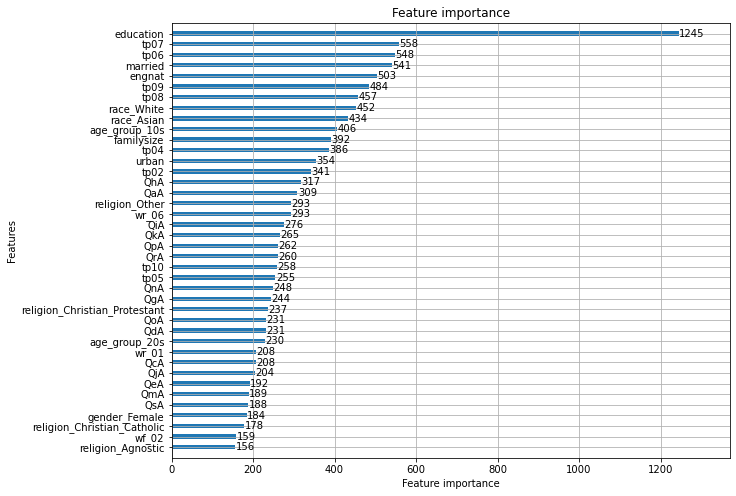

In [19]:
#피처 중요도 확인

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(clf2, ax=ax, max_num_features=40, height=0.4)

# edcation, tp07, tp06... 순으로 높은 걸 알 수 있음

---
## 최종적으로 f1값이 가장 높게 나왔던 lgbm모델을 사용해 test파일을 예측

In [22]:
X_new = test

#최적의 하이퍼 파라미터를 사용한 LGBM모델
estimator = grid_lgbm.best_estimator_

#test파일 값 예측
new_pred_class = estimator.predict(X_new)

#test파일 예측 확률 값
pred_proba = estimator.predict_proba(X_new)[:,1]

# "test_submission.csv로 저장"
sub = pd.DataFrame({'index':index, 'pred_prob':pred_proba, 'pred': new_pred_class})
sub.set_index('index', inplace=True)
sub.to_csv('test_submission.csv')

dt = pd.read_csv("test_submission.csv")
dt

,index,pred_prob,pred
0,38741,0.420640,0
1,43904,0.715387,1
2,41036,0.260265,0
3,6939,0.317184,0
4,14682,0.515380,1
...,...,...,...
9102,28225,0.538015,1
9103,5610,0.697367,1
9104,41745,0.471705,0
9105,24818,0.102033,0
